In [1]:
import mturk
import random
from datetime import datetime
import json
from pprint import pprint
import copy
import numpy as np
from collections import OrderedDict
import pandas as pd
import pymongo
import botocore
import uuid
import pdb
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import krippendorff_alpha as ka

In [69]:
def show_values_on_bars(axs, h_v="v", space_v=0, space_h=0):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2 +  + float(space_h)
                _y = p.get_y() + p.get_height() + float(space_v)
                value = round(p.get_height(),3)
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space_v)
                _y = p.get_y() + p.get_height() +  + float(space_h)
                value = round(p.get_width(),3)
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [3]:
with open('./config/mongodb_credentials.json','r') as f:
    mongodb_credentials = json.load(f)

In [4]:
""" Connect to MTurk and to the Mongodb database. Set the boolean below to TRUE to use the marketplace and to FALSE to use the sandbox (testing the HITs)"""
create_hits_in_production = True
is_pilot = False

db_client = pymongo.MongoClient(mongodb_credentials["connection_string"])
db = db_client['verbalisations']

collection_name = 'hit_results' + ('_sandbox' if not create_hits_in_production else '') + ('_pilots' if is_pilot else '')

hit_result_collection = db[collection_name]
hit_result_collection

Collection(Database(MongoClient(host=['cluster0-shard-00-01.hjstc.mongodb.net:27017', 'cluster0-shard-00-00.hjstc.mongodb.net:27017', 'cluster0-shard-00-02.hjstc.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, retrywrites=True, w='majority', authsource='admin', replicaset='Cluster0-shard-0', ssl=True), 'verbalisations'), 'hit_results')

# Analysing Campaign results

Remember to reward good feedback

In [5]:
from pprint import pprint
batches = list(db['hit_results.batches'].find())
pprint([(batch['_id'], batch['type']) for batch in batches])

[('2044d1fd-5e68-485c-b159-f3a9130942e0', 'fluency'),
 ('a86fd781-7a10-40c8-80a3-2ad7b619bbe9', 'fluency'),
 ('5db6f238-aea7-46dd-8a1d-38fd2caecc3c', 'adequacy'),
 ('ab5ea68c-0677-4c82-bed0-1b3c582dd938', 'fluency'),
 ('726cc28d-15f4-4459-94a2-442a3994817b', 'fluency'),
 ('0073d830-f299-408a-87c1-4327ba7599b7', 'adequacy')]


### Batch ids

#### First run

216 tasks, 108 fluench and 108 adequacy, analysing a total of 432 non-gd and 45 gd verbalisations (plus 45 artificially made per task type), 5 hits each.

Fluency batch id: 2044d1fd-5e68-485c-b159-f3a9130942e0, a86fd781-7a10-40c8-80a3-2ad7b619bbe9
    
Adequacy batch id: 5db6f238-aea7-46dd-8a1d-38fd2caecc3c

#### Second run

476 tasks, 238 fluench and 238 adequacy, analysing a total of 949 non-gd and 45 + 45(per task) (same as first batch) gd verbalisations, 5 hits each.

Fluency batch id: ab5ea68c-0677-4c82-bed0-1b3c582dd938, 726cc28d-15f4-4459-94a2-442a3994817b
    
Adequacy batch id: 0073d830-f299-408a-87c1-4327ba7599b7

In [6]:
data_flu = list(hit_result_collection.find(
    {'type':'fluency', 'batch_id' : {
        '$in' : [
            '2044d1fd-5e68-485c-b159-f3a9130942e0',
            'a86fd781-7a10-40c8-80a3-2ad7b619bbe9',
            'ab5ea68c-0677-4c82-bed0-1b3c582dd938',
            '726cc28d-15f4-4459-94a2-442a3994817b'
        ]
    }}))
data_ade = list(hit_result_collection.find(
    {'type':'adequacy', 'batch_id' : {
        '$in' : [
            '5db6f238-aea7-46dd-8a1d-38fd2caecc3c',
            '0073d830-f299-408a-87c1-4327ba7599b7'
        ]
    }}))
len(data_flu), len(data_ade)

(347, 346)

In [7]:
set_flu = set([b['taskSet_id'] for b in data_flu])
set_ade = set([b['taskSet_id'] for b in data_ade])

In [8]:
set_flu = set([v['claim_id'] for d in data_flu for v in d['verbalisations'] if ('GD_PLUS') not in v['claim_id']])
set_ade = set([v['claim_id'] for d in data_ade for v in d['verbalisations'] if ('GD_PLUS') not in v['claim_id']])

In [9]:
len(set_flu),len(set_ade)

(1426, 1426)

### Other Adequacy reasons

In [10]:
reason_no_other = []
reason_not_sure_other = []
for hit in data_ade:
    for answer in hit['answers']:
        for output in answer['values']['outputs']:
            if output['reason_no_other'] != '':
                reason_no_other.append(output['reason_no_other'])
            if output['reason_not_sure_other'] != '':
                reason_not_sure_other.append(output['reason_not_sure_other'])

In [11]:
reason_no_other

['description and object are different',
 'predicate is different',
 'object is different',
 'object is different',
 'Totally different',
 'predicate different',
 'Object is different',
 'Totally different',
 'The sentence is talking about István Fazekas while the triple is referring to the date of birth of  Juan Miguel Mercado.',
 'The subject and object of the triple are switched. ',
 'The subject, object, and predicate are all talking about the Tour De France in the sentence but the triple is referring to the burial site of an athlete.',
 "Karl Müller is the subject of the sentence while the triple is referring to Leroy Chiao. The objects and predicates also don't relate in any way.",
 'The predicate is "pages" but "pages" isn\'t indicated anywhere in the sentence, though it is implied at the end of the sentence with the range of numbers.',
 'The sentence, object, subject, and predicate all discuss the same thing but additional wording was added to the predicate.',
 'The triple is t

In [12]:
reason_not_sure_other

['Here the order of the subject and object are reversed which could potentially change the meaning and I am not sure whether you could infer the same meaning from the sentence and the triple because of this.',
 'subject and object are inverted',
 'ambiguous, description too vague to determine if they are the same or different',
 'The description of the object refers to a person who is a conservationist and it is unknown if it is the same person as the child. ',
 "A directeur sportif is not quite the same thing as a general manager, though it's similar enough it may be acceptable overall",
 'Is ',
 'Are the two places in the sentence located in the Czech Republic?',
 'I feel the object should have been career.  ']

### Completion time

In [13]:
df_data_times = pd.DataFrame(columns=['type','time'])

for hit in data_flu:
    for answer in hit['answers']:
        if answer['values']['outputs'] is not None:
            df_data_times = df_data_times.append({'type':'fluency', 'time': np.sum(answer['values']['times'])/1000}, ignore_index=True)
            
print(df_data_times[df_data_times['type'] == 'fluency']['time'].mean(), 'seconds is the mean fluency time')
print(df_data_times[df_data_times['type'] == 'fluency']['time'].median(), 'seconds is the median fluency time')

for hit in data_ade:
    for answer in hit['answers']:  
        if answer['values']['outputs'] is not None:
            df_data_times = df_data_times.append({'type':'adequacy', 'time': np.sum(answer['values']['times'])/1000}, ignore_index=True)


print(df_data_times[df_data_times['type'] == 'adequacy']['time'].mean(), 'seconds is the mean adequacy time')
print(df_data_times[df_data_times['type'] == 'adequacy']['time'].median(), 'seconds is the median adequacy time')

122.42097398843966 seconds is the mean fluency time
70.178 seconds is the median fluency time
211.00318323699418 seconds is the mean adequacy time
102.7245 seconds is the median adequacy time


In [14]:
# According to mean values, pay should be
MINIMUM_HOURLY_USD_WAGE = 7.25
# Fluency
AVG_HIT_TIME_SECONDS = df_data_times[df_data_times['type'] == 'fluency']['time'].mean()
AVG_HIT_TIME_HOURS = AVG_HIT_TIME_SECONDS/3600
print('Fluency:', AVG_HIT_TIME_HOURS*MINIMUM_HOURLY_USD_WAGE)
# Adequacy
AVG_HIT_TIME_SECONDS = df_data_times[df_data_times['type'] == 'adequacy']['time'].mean()
AVG_HIT_TIME_HOURS = AVG_HIT_TIME_SECONDS/3600
print('Adequacy:', AVG_HIT_TIME_HOURS*MINIMUM_HOURLY_USD_WAGE)

# I have then decided to pay 0.50 for Fluency and 1.00 for Adequacy, which over twice minimum wage considering mean time.

Fluency: 0.24654223928227434
Adequacy: 0.42493696624116883


In [15]:
df_data_times.sort_values('time')#.head(100)

,type,time
1646,fluency,19.689
1188,fluency,19.813
1269,fluency,20.164
1276,fluency,20.375
1296,fluency,20.467
...,...,...
1977,adequacy,3190.919
2248,adequacy,3441.392
1787,adequacy,4045.795
2098,adequacy,6091.634


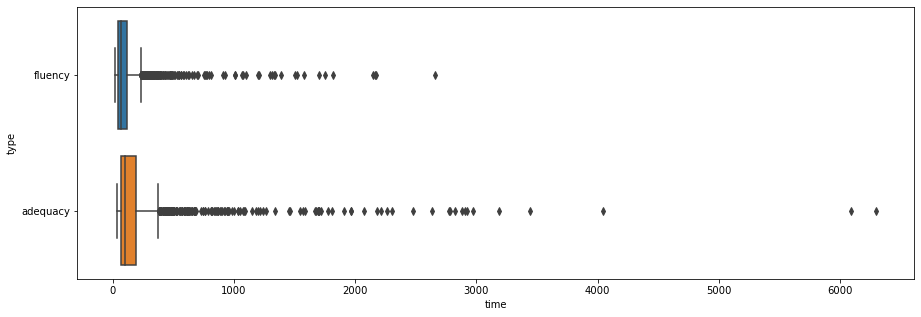

In [16]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
g = sns.boxplot(data = df_data_times, x='time', y='type')
g.set_xscale("linear")

### Feedback

In [17]:
from pprint import pprint
for p in data_flu:
    print(p['_id'])
    for a in p['answers']:
        if a['values']['feedback'] != None :
            if a['values']['feedback'].upper().strip() not in [
                'NONE','NICE','GOOD','INTERESTING','THANK YOU', 'VERY NICE', 'VERY INTERESTING'
            ] :
                print(a['worker_id'], '-', a['values']['feedback'], '-', a['assignment_id'])
    print('-----')
    print('\n')

371QPA24D506VI641JT81FLJMBN1T6
-----


373L46LKQAIENGWLXZLM4OU9XFWJKM
A1VP4HOT25NC0Y - it is interesting to do - 3N1FSUEFL9CJTC5KSDHXJT6SV7DD44
ADC4VXNQJ9FEW - Interesting task! Thanks for providing new stimuli! :D - 3KMS4QQVK6215Y8J4BZ3EAY946KFK8
-----


33NKDW9FG0UXZ2PMMQJP7EPG342CXQ
-----


39I4RL8QHMTXI8CSO7VLLUPYN12H4P
AVPZJ69E3WFYM - it is very interesting - 36NEMU28XJPY68UHFCMJXBCDOE3MWG
ADC4VXNQJ9FEW - Since I've done more than one HIT, I wish you could grant me a qualification so that I won't need to pass the English comprehension test every single time. The task is quite underpaid and if you could save us some time it would be like improving the pay. Thanks. - 3DY4FPOOA50COZ74UAD4X8N9NSZVR2
-----


3OID399FYJJQ484FMS8ELD7RKZIFD2
-----


3S37Y8CWJBCFFY7HJ6HLMXZL2PF4WC
-----


39KMGHJ4S2M58KOV7Y1Y3Z04K8K00Q
-----


3MJ9GGZYP6I857PREN25BT5WQSGA2B
-----


36818Z1KW6PXQPLAINGAU3AOW6GA3M
-----


3RWSQDNYMCYN2SIBDY349DACWCYFFD
-----


3VW0145YM1O9D4WOIBY2J1MDMKRJMR
-----


33Q5P9PUT

In [18]:
from pprint import pprint
for p in data_ade:
    print(p['_id'])
    for a in p['answers']:
        if a['values']['feedback'] != None :
            if a['values']['feedback'].upper().strip() not in [
                'NONE','NICE','GOOD','INTERESTING','THANK YOU', 'VERY NICE', 'VERY INTERESTING',
                'VERY INTERESTING.', 'VERY INTERSTING'
            ] :
                print(a['worker_id'], '-', a['values']['feedback'], '-', a['assignment_id'])
    print('-----')
    print('\n')

37SDSEDIOCENXYEGYLIDAJPW8AQ810
-----


3KG2UQJ0NM0WH9L1P2XBTHNZ5HGQN0
-----


3HRWUH63RXE7ON235A98V6S89LU5N3
-----


3WPCIUYH2DK0NDMGHCD32HMSBKDTDZ
-----


37SQU136WA05MYUVZ09YV92OU4K119
A288NRHQNCYYX9 - This survey is very interesting. - 3O6CYIULEHDHJGZQOED5OLT718UWUM
-----


3EPG8DX9MN27R8EGLPM0ZVX390V5PZ
-----


388FBO7J0U55QBCNGCE563Q14QXYNB
-----


32TMVRKDHQA4PXBZL31F8HWZKU084D
-----


3VMV5CHJ0BR3ZXW7J2EB82PPOCTTG9
A9V3FN8FBJK0Z - very good - 351SEKWQS4TZX2UQYHHT5NNSH6LMDB
A2LRY3ID0PEG82 - excellent - 3NS0A6KXC8K28T30FW8VJAMY92JGZW
-----


3UL5XDRDOFVMLGFZZ8KPD92DKQV85I
A35T79LLCN429G - good to work - 3MMN5BL1W3G1FAST5SBHSE1GQTWM3D
A2OD4LJKPZDL2J - good experience - 3BV8HQ2ZZ0DZAS6MRRJAQQI063A6AK
-----


3JMNNNO3C4G5CKSUFSYXTI2NIN6W2J
-----


3TCFMTM8IH0CBJCRI49C0SCTMAY12Q
A171SF2UF7YUN4 - nice experience I really enjoyed this study. - 3Z2R0DQ0JLQEI44XKU9TWWRFBD62EU
-----


3N7PQ0KLJ810G22MYSIWQM0FHX23EM
A3C2PSZEKN8OWD - Interesting and challenging questions to answer.Happy abou

-----


3UEBBGULQI0CLAF18NY3VDBF8AQFUD
-----


35YHTYFL2JFCYP41DD88RZDYMHZFV2
-----


3H4IKZHAMEUBEC899A5UPNSU25JNN0
-----


3MWOYZD5XY0TWX8LAP574CSZSFONOF
A1EO8NJLABVNK7 - PLEASANT. - 3SPJ033425FCU5JWRGRF2G5CZZVYJS
-----


31ODACBEOXRTXMD6XYEXSBX5UFESQ4
-----


30EMX9PEWNV7MJFBKTU0WPLWV9MKS4
-----


3LOJFQ4BP0R1KUWTN3ZB1QZWU6CDK3
A3PT15XRN1X8VE - excellent - 36ZN444YTVA45GVO3BXHOOSA8BHIO1
-----


3FO95NVK6FCT9NS6AD3XX17AQ1GSR5
A1EO8NJLABVNK7 - PLEASANT. - 3JV9LGBJWXQQ9PPTDNXE3CFUTY0GOI
-----


3W9XHF7WHN781JSQ9TZQ6UHIXS0KTT
-----


3P4ZBJFX3YFPDE463ND4D1WCTQ1FWC
-----


3VMHWJRYIYS42E9WDS9QFKAJ2S7FX5
-----


33J5JKFML9APD5SR7JDWK3PT2ZFQ3A
-----


36FQTHX306329ZQ2O1G6PEUUGZEB3J
-----


3RKHNXPHHZ8N1W7F9YP0BQ3KG67KUK
-----


3Q7TKIAPPWMC40EB83BCGQCBJ6HDL6
A2Y5598T4CQ69V - good survey - 3ZQIG0FLQISHWVOQT4NAK7VQJE2WVC
-----


3V7ICJJA0DSNRV96OFLPZJM0UZAB44
A3O8UD1HHLPBGH - Excellent - 3ZGVPD4G6XT6DYP6ZW72IT1N3VQTZJ
-----


3Y7LTZE0ZWYIQR619ZSAY5RXKFKUZG
-----


3D42WVSDIB7T2JZ6IOVSYYHS4Y1

### Non-agg Values

In [19]:
from pprint import pprint

data_flu_jsons = []
for p in data_flu:
    for a in p['answers']:
        if a['values']['outputs'] is not None:
            for i in range(6):
                data_flu_jsons.append({
                    'claim_id': p['verbalisations'][i]['claim_id'],
                    'worker_id': a['worker_id'],
                    'fluency': a['values']['outputs'][i]['fluency']
                })
data_flu_df = pd.DataFrame(data_flu_jsons).sort_values('claim_id').reset_index(drop=True)

data_ade_jsons = []
for p in data_ade:
    for a in p['answers']:
        if a['values']['outputs'] is not None:
            for i in range(6):
                data_ade_jsons.append({
                    'claim_id': p['verbalisations'][i]['claim_id'],
                    'worker_id': a['worker_id'],
                    'adequacy': a['values']['outputs'][i]['adequacy'],
                    'reason_no': a['values']['outputs'][i]['reason_no'],
                    'reason_not_sure': a['values']['outputs'][i]['reason_not_sure'],
                    
                })
data_ade_df = pd.DataFrame(data_ade_jsons).sort_values('claim_id').reset_index(drop=True)

In [20]:
# Number of individual tasks released
len(data_flu)+len(data_ade)

693

In [21]:
# Number of unique workers
pd.concat([data_flu_df.worker_id, data_ade_df.worker_id]).unique().shape

(590,)

In [22]:
# Number of individual worker contributions
data_flu_df.shape[0] + data_ade_df.shape[0]

20760

#### Workers

In [23]:
flu_worker_std = data_flu_df.groupby('worker_id').agg(list).reset_index()
flu_worker_std['num_contrib'] = flu_worker_std.fluency.apply(len)
flu_worker_std['fluency_std'] = flu_worker_std.fluency.apply(np.std)
flu_worker_std = flu_worker_std[flu_worker_std['fluency_std'] <= 0.5]#.explode('claim_id')
#flu_worker_std['fluency'] = flu_worker_std['fluency'].apply(lambda x : x[0])
#flu_worker_std = flu_worker_std[['worker_id','claim_id','fluency']]
#flu_worker_std = flu_worker_std.set_index('claim_id')
#flu_worker_std.columns = ['singular_worker_id','fluency_by_worker']
bad_workers = flu_worker_std.worker_id.to_list()

C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='worker_id', ylabel='Density'>

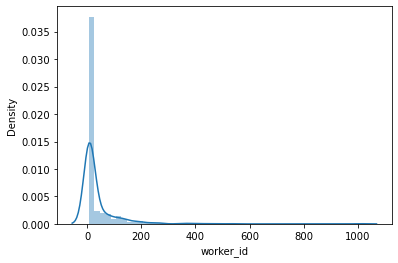

In [24]:
all_workers = pd.concat([data_flu_df, data_ade_df])['worker_id']
sns.distplot(all_workers.value_counts())

In [25]:
all_workers.value_counts()

A25SH3L1UR6Y1Z    1008
A2RKUDGK5PQ44X     528
A1TW2BZRRS874Z     438
A1IHI23KH87K5W     402
A23KAJRDVCVGOE     372
                  ... 
A1NRWXWPCAXDYP       6
A1Z8TF04ZG3VRE       6
A3IOOW5SX3UDSG       6
A2NGDOY47MIWZZ       6
A2ICS74XNZYJQZ       6
Name: worker_id, Length: 590, dtype: int64

In [26]:
#data_flu_df = data_flu_df[data_flu_df['worker_id'].apply(lambda x : x not in bad_workers)].reset_index(drop=True)
#data_ade_df = data_ade_df[data_ade_df['worker_id'].apply(lambda x : x not in bad_workers)].reset_index(drop=True)

In [27]:
data_flu_df_non_art = data_flu_df[data_flu_df['claim_id'].apply(lambda x : not x.endswith('_GD_PLUS_FLUENCY'))].reset_index(drop=True)
data_ade_df_non_art = data_ade_df[data_ade_df['claim_id'].apply(lambda x : not x.endswith('_GD_PLUS_ADEQUACY'))].reset_index(drop=True)

#### Outputs

[Text(0.5, 0, 'Simple fluency value histogram')]

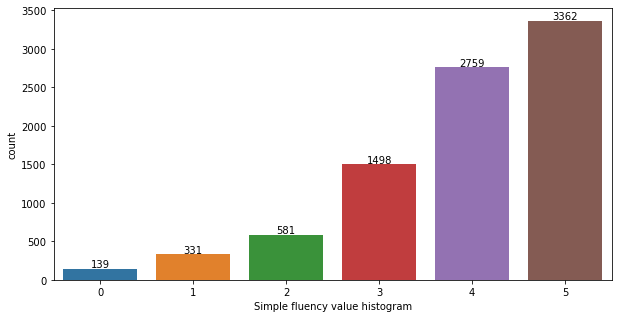

In [28]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

perc = data_flu_df_non_art.fluency.value_counts(normalize=True).mul(100).rename('percent')
sns.countplot(data=data_flu_df_non_art, x='fluency', ax=ax)
show_values_on_bars(ax, 'v', 20)
ax.set(xlabel = 'Simple fluency value histogram')

<AxesSubplot:xlabel='fluency'>

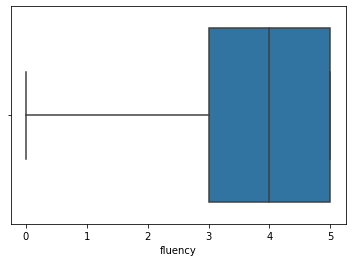

In [29]:
sns.boxplot(data=data_flu_df_non_art, x='fluency')

Minimum mean fluency per worker: 1.25
maximum mean fluency per worker: 5.0


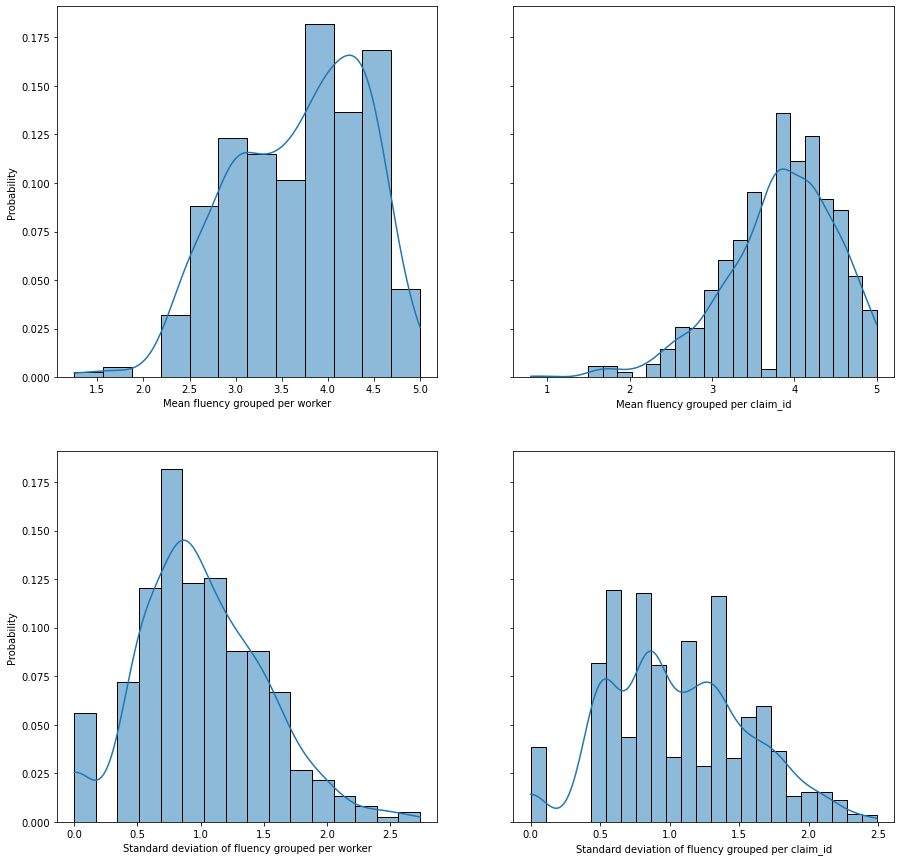

In [30]:
fig, ax = plt.subplots(2,2,figsize=(15,15), sharey=True, sharex=False)

g = sns.histplot(data = data_flu_df_non_art.groupby('worker_id').mean(), x='fluency', ax=ax[0][0], kde=True, stat='probability')
ax[0][0].set(xlabel = 'Mean fluency grouped per worker')

g = sns.histplot(data = data_flu_df_non_art.groupby('worker_id').std(), x='fluency', ax=ax[1][0], kde=True, stat='probability')
ax[1][0].set(xlabel = 'Standard deviation of fluency grouped per worker')

g = sns.histplot(data = data_flu_df_non_art.groupby('claim_id').mean(), x='fluency', ax=ax[0][1], kde=True, stat='probability')
ax[0][1].set(xlabel = 'Mean fluency grouped per claim_id')

g = sns.histplot(data = data_flu_df_non_art.groupby('claim_id').std(), x='fluency', ax=ax[1][1], kde=True, stat='probability')
ax[1][1].set(xlabel = 'Standard deviation of fluency grouped per claim_id')

print('Minimum mean fluency per worker:', data_flu_df_non_art.groupby('worker_id').mean()['fluency'].min())
print('maximum mean fluency per worker:', data_flu_df_non_art.groupby('worker_id').mean()['fluency'].max())

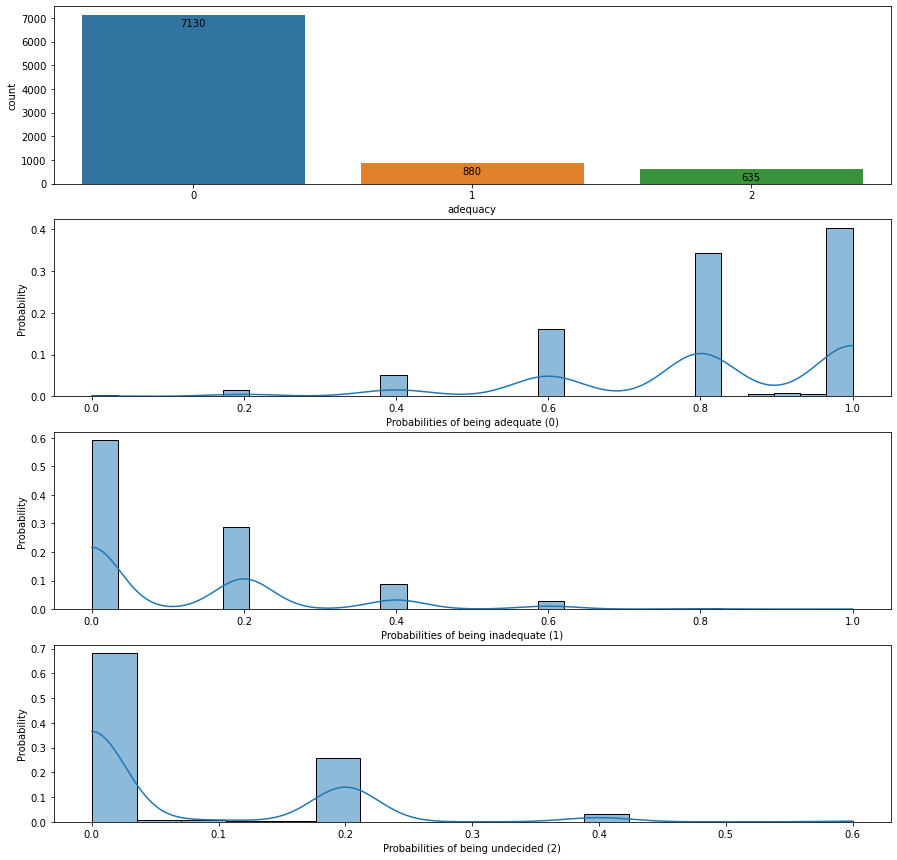

In [31]:
data_ade_df_claim = data_ade_df_non_art.groupby('claim_id')['adequacy'].apply(list).reset_index()
data_ade_df_claim['0-score'] = data_ade_df_claim.adequacy.apply(lambda x : x.count(0)/len(x))
data_ade_df_claim['1-score'] = data_ade_df_claim.adequacy.apply(lambda x : x.count(1)/len(x))
data_ade_df_claim['2-score'] = data_ade_df_claim.adequacy.apply(lambda x : x.count(2)/len(x))

fig, ax = plt.subplots(4,1,figsize=(15,15))

sns.countplot(data=data_ade_df_non_art, x='adequacy', ax=ax[0])
show_values_on_bars(ax[0], 'v', -500)
sns.histplot(data = data_ade_df_claim, ax=ax[1], kde=True, x = '0-score', stat='probability')
ax[1].set_xlabel('Probabilities of being adequate (0)')
sns.histplot(data = data_ade_df_claim, ax=ax[2], kde=True, x = '1-score', stat='probability')
ax[2].set_xlabel('Probabilities of being inadequate (1)')
sns.histplot(data = data_ade_df_claim, ax=ax[3], kde=True, x = '2-score', stat='probability')
ax[3].set_xlabel('Probabilities of being undecided (2)')

plt.show()

<ipython-input-32-0774752b8c7b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ade_df_no_labels['reason_no_label'] = data_ade_df_no_labels['reason_no'].apply(lambda x : reason_no_labels[x])
<ipython-input-32-0774752b8c7b>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ade_df_not_sure_labels['reason_not_sure_label'] = data_ade_df_not_sure_labels['reason_not_sure'].apply(lambda x : reason_not_sure_labels[x])


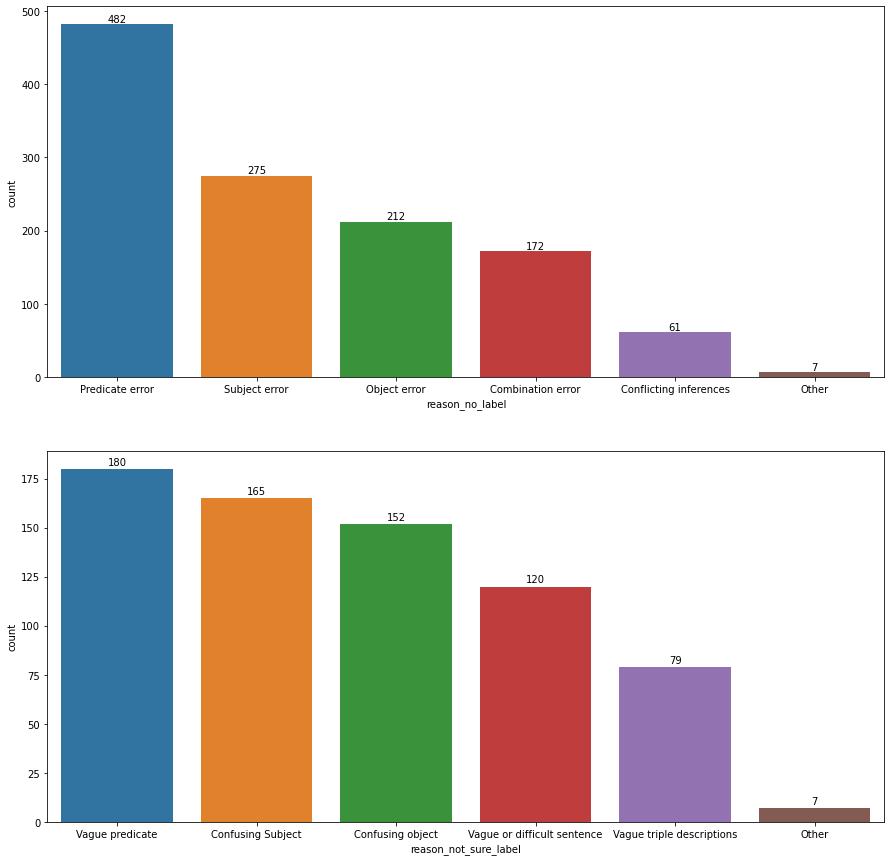

In [32]:
fig, ax = plt.subplots(2,1,figsize=(15,15))

data_ade_df_no_labels = data_ade_df_non_art[data_ade_df_non_art['reason_no'] != -1]
reason_no_labels = [
    'Subject error',
    'Predicate error',
    'Object error',
    'Combination error',
    'Conflicting inferences',
    'Other'
]
data_ade_df_no_labels['reason_no_label'] = data_ade_df_no_labels['reason_no'].apply(lambda x : reason_no_labels[x])

data_ade_df_not_sure_labels = data_ade_df_non_art[data_ade_df_non_art['reason_not_sure'] != -1]
reason_not_sure_labels = [
    'Confusing Subject',
    'Vague predicate',
    'Confusing object',
    'Vague or difficult sentence',
    'Vague triple descriptions',
    'Other'
]
data_ade_df_not_sure_labels['reason_not_sure_label'] = data_ade_df_not_sure_labels['reason_not_sure'].apply(lambda x : reason_not_sure_labels[x])

sns.countplot(data=data_ade_df_no_labels, x='reason_no_label', ax=ax[0],
             order=data_ade_df_no_labels.reason_no_label.value_counts().keys())
show_values_on_bars(ax[0], 'v', 3)

sns.countplot(data=data_ade_df_not_sure_labels, x='reason_not_sure_label', ax=ax[1],
             order=data_ade_df_not_sure_labels.reason_not_sure_label.value_counts().keys())
show_values_on_bars(ax[1], 'v', 2)

plt.show()

### Agreement

In [33]:
def prep_for_kripp(df, col, fun=np.min, fillna = None):
    '''
    WE TAKE THE MIN HERE, UNDER THE PREMISE THAT IF A WORKER SAW THE SAME SENTENCE TWICE AND GAVE IT TWO SCORES,
    THE LESSER SCORE WOULD REFLECT DIFFICULTIES THE WORKER HAD THAT MIGHT NOT HAVE BEEN ON THEIR MIND DURING THE
    GREATER SCORE ASSIGNMENT, BUT THAT ARE REAL NONETHELESS AND MUST BE REPORTED
    '''
    df = df.copy()
    df = df[['worker_id','claim_id',col]].groupby(['worker_id','claim_id']).agg(fun).reset_index()
    df = df.pivot(index='worker_id',columns='claim_id',values=col)
    if fillna:
        df = df.fillna('*')
    return df

def prep_for_fleiss(df, col):
    df = df.copy()    
    df = df[['claim_id',col]]
    df['count'] = 1
    df = df.groupby(['claim_id',col]).sum().reset_index()
    df = df.pivot(index='claim_id', columns=col, values='count').fillna(0)
    df = df[df.apply(lambda x : sum(x) == 5.0, axis=1)]
    return df

def prep_for_icc(df):
    df = df.copy()   
    ref_count = df['claim_id'].value_counts().reset_index()
    not_repeated = list(ref_count[ref_count['claim_id'] == 5]['index'])

    df = df[df['claim_id'].apply(lambda x : x in not_repeated)]
    df = df.sort_values('claim_id')
    df['raters'] = ['A','B','C','D','E']*(df.shape[0]//5)
    return df

In [34]:
import krippendorff_alpha as ka 
from statsmodels.stats.inter_rater import fleiss_kappa as fleiss

def calculate_aggreement(data_flu_df, data_ade_df=None):
    
    if data_ade_df is None:
        data_ade_df = data_flu_df

    aggr_levels_relevancy = {}

    aggr_levels_relevancy['fluency'] = {}

    data_flu_df_kripp = prep_for_kripp(data_flu_df, 'fluency',fillna='*')
    data_flu_df_fleiss = prep_for_fleiss(data_flu_df,'fluency')

    aggr_levels_relevancy['fluency']['kalpha'] = ka.krippendorff_alpha(
        data_flu_df_kripp.values, ka.interval_metric, missing_items='*'
    )
    aggr_levels_relevancy['fluency']['fkappa'] = fleiss(data_flu_df_fleiss)
    aggr_levels_relevancy['fluency']['rkappa'] = fleiss(data_flu_df_fleiss, method = 'rand')

    aggr_levels_relevancy['adequacy'] = {}

    data_ade_df_kripp = prep_for_kripp(data_ade_df, 'adequacy', fillna='*')
    data_ade_df_fleiss = prep_for_fleiss(data_ade_df,'adequacy')

    aggr_levels_relevancy['adequacy']['kalpha'] = ka.krippendorff_alpha(
        data_ade_df_kripp.values, ka.nominal_metric, missing_items='*'
    )
    aggr_levels_relevancy['adequacy']['fkappa'] = fleiss(data_ade_df_fleiss)
    aggr_levels_relevancy['adequacy']['rkappa'] = fleiss(data_ade_df_fleiss, method = 'rand')
    
    return aggr_levels_relevancy

calculate_aggreement(data_flu_df, data_ade_df)

{'fluency': {'kalpha': 0.42728116235509617,
  'fkappa': 0.052177349651634106,
  'rkappa': 0.17715529753265605},
 'adequacy': {'kalpha': 0.4583041909942204,
  'fkappa': 0.05226726813835758,
  'rkappa': 0.5498911465892597}}

In [35]:
import krippendorff_alpha as ka 
from statsmodels.stats.inter_rater import fleiss_kappa as fleiss

def calculate_aggreement_2(data_ade_df):
    data_ade_df = data_ade_df.copy()
    
    aggr_levels_relevancy = {}

    aggr_levels_relevancy['reason_no'] = {}

    data_ade_df_reason_no = data_ade_df#[data_ade_df['reason_no'] != -1]
    data_ade_df_reason_no_kripp = prep_for_kripp(data_ade_df_reason_no, 'reason_no',fillna='*')
    data_ade_df_reason_no_fleiss = prep_for_fleiss(data_ade_df_reason_no,'reason_no')

    aggr_levels_relevancy['reason_no']['kalpha'] = ka.krippendorff_alpha(
        data_ade_df_reason_no_kripp.values, ka.nominal_metric, missing_items='*'
    )
    aggr_levels_relevancy['reason_no']['fkappa'] = fleiss(data_ade_df_reason_no_fleiss)
    aggr_levels_relevancy['reason_no']['rkappa'] = fleiss(data_ade_df_reason_no_fleiss, method = 'rand')

    aggr_levels_relevancy['reason_not_sure'] = {}

    data_ade_df_reason_not_sure = data_ade_df#[data_ade_df['reason_not_sure'] != -1]
    data_ade_df_reason_not_sure_kripp = prep_for_kripp(data_ade_df_reason_not_sure, 'reason_not_sure',fillna='*')
    data_ade_df_reason_not_sure_fleiss = prep_for_fleiss(data_ade_df_reason_not_sure,'reason_not_sure')

    aggr_levels_relevancy['reason_not_sure']['kalpha'] = ka.krippendorff_alpha(
        data_ade_df_reason_not_sure_kripp.values, ka.nominal_metric, missing_items='*'
    )
    aggr_levels_relevancy['reason_not_sure']['fkappa'] = fleiss(data_ade_df_reason_not_sure_fleiss)
    aggr_levels_relevancy['reason_not_sure']['rkappa'] = fleiss(data_ade_df_reason_not_sure_fleiss, method = 'rand')
    
    return aggr_levels_relevancy

calculate_aggreement_2(data_ade_df)

{'reason_no': {'kalpha': 0.30111597898604214,
  'fkappa': 0.04713928894622993,
  'rkappa': 0.7130745041122399},
 'reason_not_sure': {'kalpha': 0.013933063778587274,
  'fkappa': 0.012813643469739195,
  'rkappa': 0.8283018867924526}}

### Aggregated results

In [36]:
data_flu_df_agg = data_flu_df_non_art.copy()
data_flu_df_agg = data_flu_df_agg.groupby('claim_id').agg(list)
data_flu_df_agg['fluency_mean'] = data_flu_df_agg['fluency'].apply(np.mean)
data_flu_df_agg['fluency_median'] = data_flu_df_agg['fluency'].apply(np.median)
data_flu_df_agg.head()

,worker_id,fluency,fluency_mean,fluency_median
claim_id,,,,
Q100147574$7EB79947-48A6-417B-862F-47EF7883E769,"[A3FUTMLIR91OLE, A1BI34TAR8H9R0, A28OYCLRGGCZ9...","[5, 0, 3, 0, 4]",2.4,3.0
Q100165454$58d5720a-40a2-80b5-d189-46cb9dfe068f,"[A243MPGSWX1HPB, A2NAKIXS3DVGAA, A30YR5TPOKQYX...","[5, 4, 3, 4, 5]",4.2,4.0
Q1002490$97cad921-42c7-4aab-bfd0-a1e8fe2753dd,"[ALJ70B2J04YR7, AAWX7QFQUNM6D, A26GR4X783R1O9,...","[4, 4, 3, 1, 3]",3.0,3.0
Q100263732$5800512a-4227-202b-9451-69da3a8545c1,"[AVPZJ69E3WFYM, ADC4VXNQJ9FEW, A9LXSGXZM4IJE, ...","[3, 5, 2, 1, 4]",3.0,3.0
Q100312969$be560579-40db-4542-142b-a55d51552185,"[A1TW2BZRRS874Z, A16OE8ECS5IXV7, A2NU3PH7NF0UW...","[5, 4, 5, 4, 5]",4.6,5.0


In [37]:
from collections import Counter


def get_adequacy_majority(X): #This actually gets the majority of any list of integers
    counts = Counter(X).most_common(3)
    if counts[0][1] > len(X)/2:
        return counts[0][0]
    else:
        highest = []
        for c in counts:
            if c[1] == counts[0][1]:
                highest.append(c)
        return np.max([c[0] for c in highest])
    
def get_adequacy_percentage(row):
    if row['adequacy_maj'] == 2:
        return 0
    else:
        return 1 - np.mean([x if x != 2 else 1 for x in row['adequacy'] ])
    
def get_reason_no_maj(row):
    if row['adequacy_maj'] in [0,2]:
        return -1
    elif row['adequacy_maj'] == 1:
        return get_adequacy_majority(row['reason_no'])
    
def get_reason_not_sure_maj(row):
    if row['adequacy_maj'] in [0,1]:
        return -1
    elif row['adequacy_maj'] == 2:
        return get_adequacy_majority(row['reason_not_sure'])
    
data_ade_df_agg = data_ade_df_non_art.copy()
data_ade_df_agg = data_ade_df_agg.groupby('claim_id').agg(list)
data_ade_df_agg['adequacy_maj'] = data_ade_df_agg['adequacy'].apply(get_adequacy_majority)
#data_ade_df_agg['adequacy+_maj'] = data_ade_df_agg['adequacy+'].apply(get_adequacy_majority)
data_ade_df_agg['adequacy_perc'] = data_ade_df_agg.apply(get_adequacy_percentage, axis=1)
data_ade_df_agg['reason_no_maj'] = data_ade_df_agg.apply(get_reason_no_maj, axis=1)
data_ade_df_agg['reason_not_sure_maj'] = data_ade_df_agg.apply(get_reason_not_sure_maj, axis=1)
data_ade_df_agg.head()

,worker_id,adequacy,reason_no,reason_not_sure,adequacy_maj,adequacy_perc,reason_no_maj,reason_not_sure_maj
claim_id,,,,,,,,
Q100147574$7EB79947-48A6-417B-862F-47EF7883E769,"[A1ZPYWVGINCZP8, A1W7F4L83SEZXF, AIYIHVU4SVNP1...","[0, 0, 0, 0, 0]","[-1, -1, -1, -1, -1]","[-1, -1, -1, -1, -1]",0,1.0,-1,-1
Q100165454$58d5720a-40a2-80b5-d189-46cb9dfe068f,"[A2EED8VKU53MH1, A3MG9XS4W3FGOA, A2Z8I8HHR1CNR...","[0, 0, 0, 2, 0]","[-1, 1, -1, -1, -1]","[-1, -1, -1, 2, -1]",0,0.8,-1,-1
Q1002490$97cad921-42c7-4aab-bfd0-a1e8fe2753dd,"[A1AWR7C38PW42P, A2XU0KK2P1FXSC, A3KOWY3F88WP9...","[0, 2, 0, 0, 0]","[-1, -1, -1, -1, -1]","[-1, 2, -1, -1, -1]",0,0.8,-1,-1
Q100263732$5800512a-4227-202b-9451-69da3a8545c1,"[AMWN796XA8EMA, A34DVO1CLLH8HR, A35T79LLCN429G...","[1, 0, 1, 0, 0]","[4, -1, 1, -1, -1]","[-1, -1, 4, -1, -1]",0,0.6,-1,-1
Q100312969$be560579-40db-4542-142b-a55d51552185,"[AEBY6S5MX5O8R, A273PAYHIAJHO7, AKMIORNF40ST7,...","[0, 0, 0, 0, 0]","[-1, -1, -1, -1, -1]","[-1, -1, -1, -1, -1]",0,1.0,-1,-1


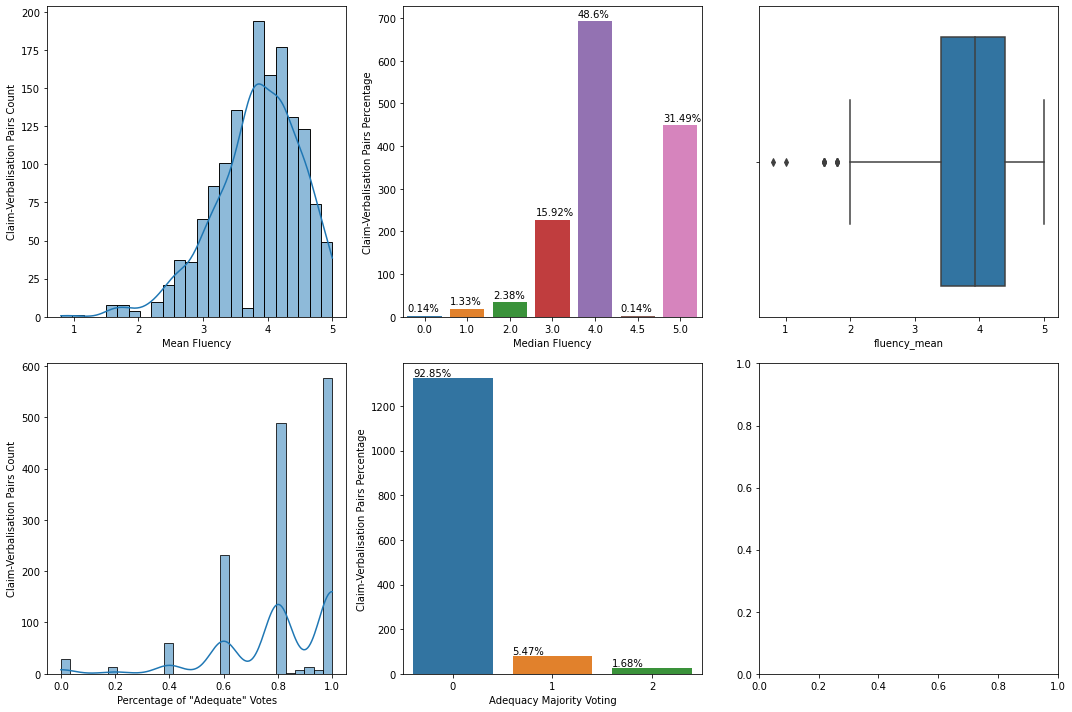

In [38]:
def print_agg_plots(data_flu_df_agg, data_ade_df_agg=None):
    
    if data_ade_df_agg is None:
        data_ade_df_agg = data_flu_df_agg

    fig, ax = plt.subplots(2,3,figsize=(15,10))

    g1 = sns.histplot(data=data_flu_df_agg, x='fluency_mean', ax=ax[0][0], kde=True)
    g2 = sns.countplot(data=data_flu_df_agg, x='fluency_median', ax=ax[0][1])

    for p in g2.patches:
        txt = str((p.get_height()/data_flu_df_agg.shape[0]*100).round(2)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height() + 10
        g2.text(txt_x,txt_y,txt)

    g3 = sns.boxplot(data=data_flu_df_agg, x='fluency_mean', ax=ax[0][2])
    
    g4 = sns.histplot(data=data_ade_df_agg, x='adequacy_perc', ax=ax[1][0], kde=True)
    g5 = sns.countplot(data=data_ade_df_agg, x='adequacy_maj', ax=ax[1][1])

    for p in g5.patches:
        txt = str((p.get_height()/data_ade_df_agg.shape[0]*100).round(2)) + '%'
        txt_x = p.get_x()
        txt_y = p.get_height() + 10
        g5.text(txt_x,txt_y,txt)
        
    ax[0][0].set_xlabel('Mean Fluency')
    ax[0][0].set_ylabel('Claim-Verbalisation Pairs Count')
    
    
    ax[0][1].set_xlabel('Median Fluency')
    ax[0][1].set_ylabel('Claim-Verbalisation Pairs Percentage')
    
    ax[1][0].set_xlabel('Percentage of "Adequate" Votes')
    ax[1][0].set_ylabel('Claim-Verbalisation Pairs Count')
    
    ax[1][1].set_xlabel('Adequacy Majority Voting')
    ax[1][1].set_ylabel('Claim-Verbalisation Pairs Percentage')
    
    plt.tight_layout()
    plt.savefig('imgs/agg_metrics.png', bbox_inches='tight')
    plt.show()

print_agg_plots(data_flu_df_agg, data_ade_df_agg)

<ipython-input-39-63c083a7c282>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ade_df_agg_no_labels['reason_no_maj_label'] = data_ade_df_agg_no_labels['reason_no_maj'].apply(lambda x : reason_no_labels[x])
<ipython-input-39-63c083a7c282>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ade_df_agg_not_sure_labels['reason_not_sure_maj_label'] = data_ade_df_agg_not_sure_labels['reason_not_sure_maj'].apply(lambda x : reason_not_sure_labels[x])


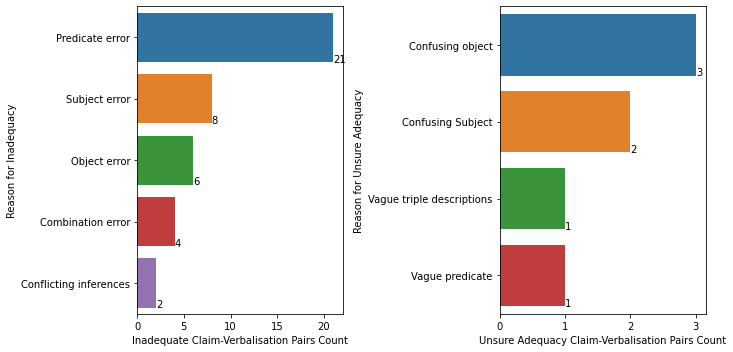

In [39]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

data_ade_df_agg_no_labels = data_ade_df_agg[data_ade_df_agg['reason_no_maj'] != -1]
data_ade_df_agg_no_labels['reason_no_maj_label'] = data_ade_df_agg_no_labels['reason_no_maj'].apply(lambda x : reason_no_labels[x])

data_ade_df_agg_not_sure_labels = data_ade_df_agg[data_ade_df_agg['reason_not_sure_maj'] != -1]
data_ade_df_agg_not_sure_labels['reason_not_sure_maj_label'] = data_ade_df_agg_not_sure_labels['reason_not_sure_maj'].apply(lambda x : reason_not_sure_labels[x])

sns.countplot(data=data_ade_df_agg_no_labels, y='reason_no_maj_label', ax=ax[0],
             order=data_ade_df_agg_no_labels.reason_no_maj_label.value_counts().keys())
ax[0].set_xlabel('Inadequate Claim-Verbalisation Pairs Count')
ax[0].set_ylabel('Reason for Inadequacy')
show_values_on_bars(ax[0], 'h', 0)

sns.countplot(data=data_ade_df_agg_not_sure_labels, y='reason_not_sure_maj_label', ax=ax[1],
             order=data_ade_df_agg_not_sure_labels.reason_not_sure_maj_label.value_counts().keys())
ax[1].set_xlabel('Unsure Adequacy Claim-Verbalisation Pairs Count')
ax[1].set_ylabel('Reason for Unsure Adequacy')
show_values_on_bars(ax[1], 'h', 0)

plt.tight_layout()
plt.savefig('imgs/no_not_sure_reasons_agg.png', bbox_inches='tight' )
plt.show()

In [40]:
np.mean(data_flu_df_agg.fluency_median >= 3)

0.9614305750350631

In [41]:
np.mean(data_ade_df_agg.adequacy_perc >= 0.8)

0.7664796633941094

# Analysis per theme

In [42]:
claims_df = pd.read_csv('./data/campaign/campaign_sampled_df_verbalised_english.csv')
claims_df = claims_df.set_index('claim_id')
crowd_agg = data_flu_df_agg.drop('worker_id',axis=1).join(data_ade_df_agg.drop('worker_id',axis=1), on='claim_id',)
claims_crowd_df = claims_df.join(crowd_agg, how='inner')

In [43]:
theme_groups = {
    'WEBNLG_SEEN':[
        'Airport', 'Astronaut', 'Building', 'City', 'ComicsCharacter',
        'Food', 'Monument', 'SportsTeam', 'University', 'WrittenWork'
    ],
    'WEBNLG_UNSEEN': [
        'Athlete', 'Artist', 'CelestialBody', 'MeanOfTransportation', 'Politician'
    ],
    'WIKIDATA_UNSEEN': [
        'ChemicalCompound', 'Mountain', 'Painting', 'Street', 'Taxon'
    ]
}

def get_theme_group(theme):
    for theme_group in theme_groups:
        if theme in theme_groups[theme_group]:
            return theme_group
        
def count_not_none_language(row, column_type):
    c = 0
    for element in ['entity','property','object']:
        if row[f'{element}_{column_type}_lan'] != 'none':
            c+=1
    return c
    

claims_crowd_df['had_labels'] = claims_crowd_df.apply(
    lambda x: count_not_none_language(x,'label'), axis=1
)

claims_crowd_df['had_descriptions'] = claims_crowd_df.apply(
    lambda x: count_not_none_language(x,'desc'), axis=1
)

claims_crowd_df['had_aliases'] = claims_crowd_df.apply(
    lambda x: count_not_none_language(x,'alias'), axis=1
)

In [44]:
claims_crowd_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1426 entries, Q20451714$49CB1F7A-FC51-41CF-81EA-3EC1EC81AB5D to Q24021863$66ED4E2A-0EA7-4B6A-8CE9-17135C6A0CEE
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   entity_id                1426 non-null   object 
 1   rank                     1426 non-null   object 
 2   property_id              1426 non-null   object 
 3   datatype                 1426 non-null   object 
 4   datavalue                1426 non-null   object 
 5   sampling_weight_vb       1426 non-null   object 
 6   sampling_weight          1426 non-null   float64
 7   entity_label             1426 non-null   object 
 8   property_label           1426 non-null   object 
 9   object_label             1426 non-null   object 
 10  theme_entity_id          1426 non-null   object 
 11  theme_entity_label       1426 non-null   object 
 12  entity_desc              1426 non-null   object 
 

In [45]:
claims_crowd_df.head()

,entity_id,rank,property_id,datatype,datavalue,sampling_weight_vb,sampling_weight,entity_label,property_label,object_label,...,adequacy,reason_no,reason_not_sure,adequacy_maj,adequacy_perc,reason_no_maj,reason_not_sure_maj,had_labels,had_descriptions,had_aliases
claim_id,,,,,,,,,,,,,,,,,,,,,
Q20451714$49CB1F7A-FC51-41CF-81EA-3EC1EC81AB5D,Q20451714,normal,P366,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",37|14,2.642857,Livramento Do Brumado Airport,use,general aviation,...,"[1, 0, 0, 0, 0]","[2, -1, -1, -1, -1]","[-1, -1, -1, -1, -1]",0,0.8,-1,-1,3,3,3
Q1655953$CAAADB1F-5DCA-4492-8707-EEAAAE8C7035,Q1655953,normal,P366,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",37|14,2.642857,Confresa Airport,use,general aviation,...,"[2, 0, 0, 1, 0]","[-1, 2, -1, 4, -1]","[0, -1, -1, -1, -1]",0,0.6,-1,-1,3,3,3
Q12692647$4C0066D0-8B10-433F-88F1-6AA6B01EE058,Q12692647,normal,P366,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",37|14,2.642857,Fazenda Bananeira Airport,use,general aviation,...,"[0, 0, 0, 0, 1]","[-1, -1, -1, -1, 2]","[-1, -1, -1, -1, -1]",0,0.8,-1,-1,3,3,3
Q7589682$2dd0b4b8-4b51-8876-1a25-4adf01ccfbf4,Q7589682,normal,P366,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",37|14,2.642857,St. Louis Regional Airport,use,air taxi,...,"[0, 0, 1, 0, 0]","[2, 1, 2, -1, -1]","[-1, -1, -1, -1, -1]",0,0.8,-1,-1,3,3,2
Q9586474$814EF1BE-6ACE-4627-9EF1-D0C4A24DFE3F,Q9586474,normal,P366,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",37|14,2.642857,Santa Rosa do Purus Airport,use,general aviation,...,"[0, 0, 0, 0, 0]","[1, -1, -1, -1, 3]","[-1, -1, -1, 1, -1]",0,1.0,-1,-1,3,3,3


In [46]:
#claims_crowd_df.to_csv('data/campaign/crowdsourced_campaign_sampled_df_verbalised_english.csv')

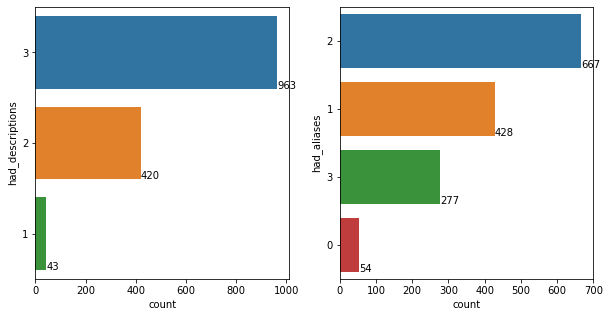

In [47]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

sns.countplot(
    data=claims_crowd_df, y='had_descriptions', orient='v',
    order=claims_crowd_df.had_descriptions.value_counts().keys(), ax=ax[0]
)
show_values_on_bars(ax[0], 'h', 0)

sns.countplot(
    data=claims_crowd_df, y='had_aliases', orient='v',
    order=claims_crowd_df.had_aliases.value_counts().keys(), ax=ax[1]
)
show_values_on_bars(ax[1], 'h', 0)

plt.show()

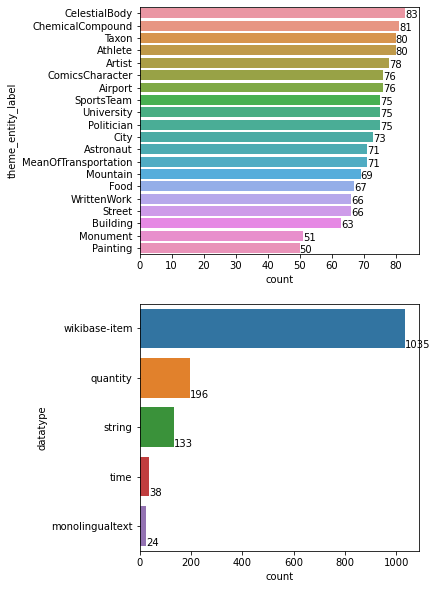

In [48]:
fig, ax = plt.subplots(2,1,figsize=(5,10))

sns.countplot(
    data=claims_crowd_df, y='theme_entity_label', orient='v',
    order=claims_crowd_df.theme_entity_label.value_counts().keys(), ax=ax[0]
)
show_values_on_bars(ax[0], 'h', 0)

sns.countplot(
    data=claims_crowd_df, y='datatype', orient='v',
    order=claims_crowd_df.datatype.value_counts().keys(), ax=ax[1]
)
show_values_on_bars(ax[1], 'h', 0)

plt.show()

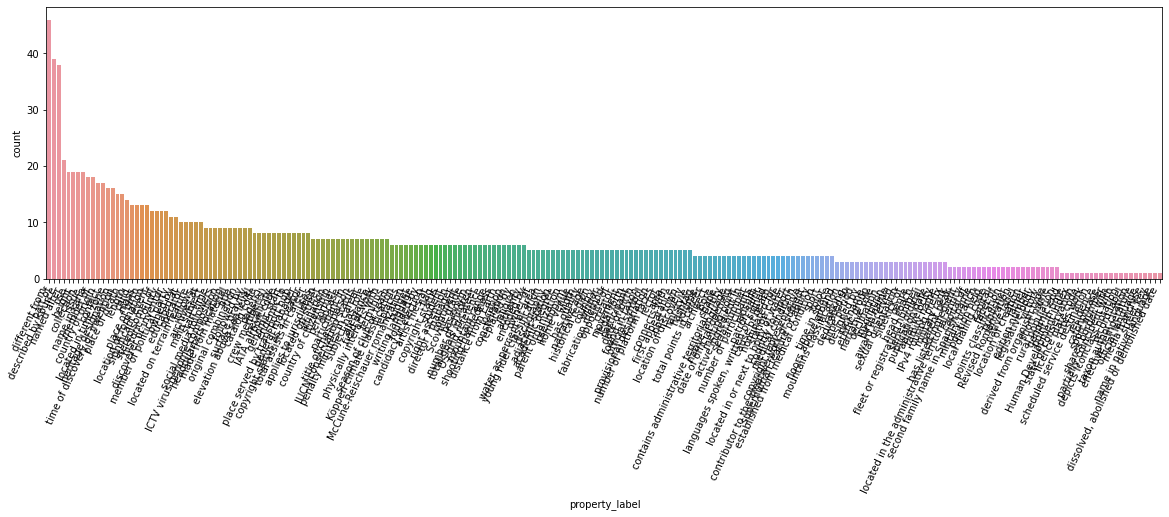

In [49]:
fig, ax = plt.subplots(1,1,figsize=(20,5))

g = sns.countplot(
    data=claims_crowd_df, x='property_label', orient='v',
    order=claims_crowd_df.property_label.value_counts().keys(), ax=ax
)
g.set_xticklabels(g.get_xticklabels(), rotation=65,ha='right')
plt.show()

## Varying agreement

In [50]:
claims_art = data_flu_df[data_flu_df['claim_id'].apply(lambda x : '_GD_PLUS_' in x)].claim_id.tolist()
claims_art += data_ade_df[data_ade_df['claim_id'].apply(lambda x : '_GD_PLUS_' in x)].claim_id.tolist()

In [108]:
theme_entity_label_claim_lookup = claims_crowd_df.reset_index()[['claim_id','theme_entity_label']].groupby('theme_entity_label').agg(list)

aggreement_per_theme = []

for theme in theme_entity_label_claim_lookup.index.tolist():
    claims = theme_entity_label_claim_lookup.loc[theme,'claim_id']
    claims += claims_art
       
    data_flu_df_theme = data_flu_df[data_flu_df['claim_id'].apply(lambda x : x in claims)]
    data_ade_df_theme = data_ade_df[data_ade_df['claim_id'].apply(lambda x : x in claims)]
    agg_dict = calculate_aggreement(data_flu_df_theme, data_ade_df_theme)
    aggreement_per_theme.append({
        'theme':theme,
        'fluency_kalpha':agg_dict['fluency']['kalpha'],
        'fluency_fkappa':agg_dict['fluency']['fkappa'],
        'fluency_rkappa':agg_dict['fluency']['rkappa'],
        'adequacy_kalpha':agg_dict['adequacy']['kalpha'],
        'adequacy_fkappa':agg_dict['adequacy']['fkappa'],
        'adequacy_rkappa':agg_dict['adequacy']['rkappa'],
    })
    
aggreement_per_theme = pd.DataFrame(aggreement_per_theme)
aggreement_per_theme['theme_group'] = aggreement_per_theme['theme'].apply(get_theme_group)
aggreement_per_theme

,theme,fluency_kalpha,fluency_fkappa,fluency_rkappa,adequacy_kalpha,adequacy_fkappa,adequacy_rkappa,theme_group
0,Airport,0.522681,0.054851,0.211200,0.665715,0.006875,0.594000,WEBNLG_SEEN
1,Artist,0.540737,-0.004320,0.161579,0.654865,0.084470,0.571711,WEBNLG_UNSEEN
2,Astronaut,0.554482,0.023561,0.276571,0.671740,0.076888,0.605714,WEBNLG_SEEN
3,Athlete,0.538854,0.069717,0.263291,0.629367,0.015088,0.515823,WEBNLG_UNSEEN
4,Building,0.469057,0.035590,0.177419,0.655689,0.043568,0.680645,WEBNLG_SEEN
5,CelestialBody,0.454879,0.029887,0.127000,0.612802,0.010897,0.446875,WEBNLG_UNSEEN
6,ChemicalCompound,0.427306,0.101980,0.180000,0.635413,0.073925,0.513924,WIKIDATA_UNSEEN
7,City,0.468588,0.012364,0.145205,0.630907,0.078413,0.558219,WEBNLG_SEEN
8,ComicsCharacter,0.561066,0.024098,0.235616,0.676374,0.042602,0.564583,WEBNLG_SEEN
9,Food,0.455924,0.030869,0.145231,0.622996,0.049371,0.503846,WEBNLG_SEEN


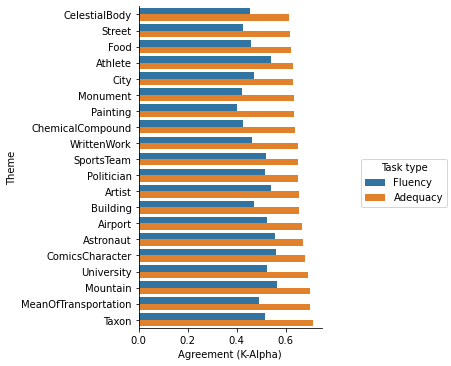

C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\gabri\anaconda3\envs\phd\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


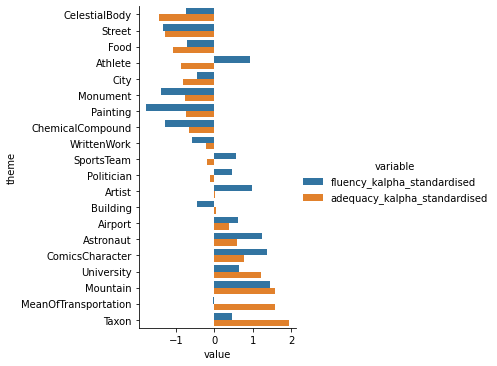

In [109]:
aggreement_per_theme_kalpha = aggreement_per_theme[['theme','fluency_kalpha','adequacy_kalpha']]
aggreement_per_theme_melt = aggreement_per_theme_kalpha.melt(id_vars='theme')

g = sns.catplot(x='value', y='theme', data=aggreement_per_theme_melt, hue='variable', kind='bar',
           order=aggreement_per_theme.sort_values('adequacy_kalpha').theme.tolist() )
legend = g._legend
legend.set_title("Task type")
legend.set_frame_on(True)
for t, l in zip(legend.texts,("Fluency", "Adequacy")):
    t.set_text(l)
g.set(xlabel = "Agreement (K-Alpha)", ylabel = "Theme")

plt.savefig('imgs/agree_per_theme.png', bbox_inches='tight')
plt.show()

aggreement_per_theme_kalpha.loc[:,'adequacy_kalpha_standardised'] = (aggreement_per_theme_kalpha['adequacy_kalpha'] - aggreement_per_theme_kalpha['adequacy_kalpha'].mean())/aggreement_per_theme_kalpha['adequacy_kalpha'].std()
aggreement_per_theme_kalpha.loc[:,'fluency_kalpha_standardised'] = (aggreement_per_theme_kalpha['fluency_kalpha'] - aggreement_per_theme_kalpha['fluency_kalpha'].mean())/aggreement_per_theme_kalpha['fluency_kalpha'].std()

columns_standardised = ['theme', 'fluency_kalpha_standardised', 'adequacy_kalpha_standardised']
aggreement_per_theme_melt_standardised = aggreement_per_theme_kalpha[columns_standardised].melt(id_vars='theme')

columns = ['fluency_kalpha_standardised', 'adequacy_kalpha_standardised']
sns.catplot(x='value', y='theme', data=aggreement_per_theme_melt_standardised, hue='variable', kind='bar',
           order=aggreement_per_theme_kalpha.sort_values('adequacy_kalpha').theme.tolist() )

plt.savefig('imgs/agree_per_theme_standardised.png', bbox_inches='tight')
#plt.tight_layout()
plt.show()

In [110]:
aggreement_per_theme_kalpha.corr()

,fluency_kalpha,adequacy_kalpha,adequacy_kalpha_standardised,fluency_kalpha_standardised
fluency_kalpha,1.000000,0.636521,0.636521,1.000000
adequacy_kalpha,0.636521,1.000000,1.000000,0.636521
adequacy_kalpha_standardised,0.636521,1.000000,1.000000,0.636521
fluency_kalpha_standardised,1.000000,0.636521,0.636521,1.000000


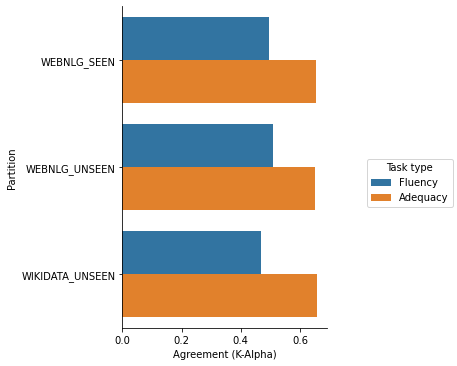

In [111]:
aggreement_per_theme_kalpha = aggreement_per_theme[['theme','fluency_kalpha','adequacy_kalpha','theme_group']]
aggreement_per_theme_kalpha_melt = aggreement_per_theme_kalpha.melt(id_vars=['theme','theme_group'])

g = sns.catplot(x='value', y='theme_group', data=aggreement_per_theme_kalpha_melt, hue='variable', kind='bar', ci=None)

legend = g._legend
legend.set_title("Task type")
legend.set_frame_on(True)
for t, l in zip(legend.texts,("Fluency", "Adequacy")):
    t.set_text(l)
g.set(xlabel = "Agreement (K-Alpha)", ylabel = "Partition")

plt.savefig('imgs/agree_per_partition.png', bbox_inches='tight')
plt.show()

In [112]:
aggreement_per_theme_kalpha_melt.groupby(['theme_group','variable']).agg({'value':['mean','std']})

value          
                                     mean       std
theme_group     variable                           
WEBNLG_SEEN     adequacy_kalpha  0.654175  0.021680
                fluency_kalpha   0.496089  0.046440
WEBNLG_UNSEEN   adequacy_kalpha  0.649527  0.032883
                fluency_kalpha   0.508015  0.036087
WIKIDATA_UNSEEN adequacy_kalpha  0.659174  0.042720
                fluency_kalpha   0.466761  0.070145

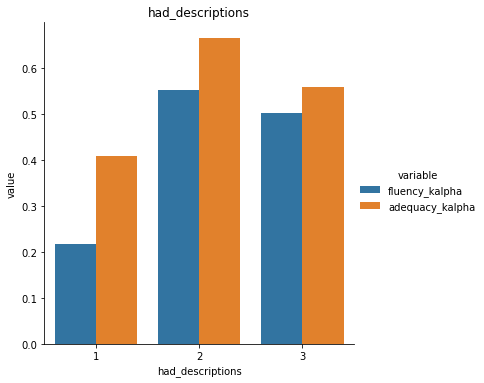

   had_descriptions         variable     value
0                 1   fluency_kalpha  0.216459
1                 2   fluency_kalpha  0.552863
2                 3   fluency_kalpha  0.502522
3                 1  adequacy_kalpha  0.409134
4                 2  adequacy_kalpha  0.666120
5                 3  adequacy_kalpha  0.558172
                  had_descriptions    value
had_descriptions           1.00000  0.78829
value                      0.78829  1.00000
                  had_descriptions    value
had_descriptions           1.00000  0.57749
value                      0.57749  1.00000


In [61]:
# I AM REPEATING THE CODE STRUCTURE AND JUST CHANGING THE NAME OF THE COLUMN, DONT JUDGE ME
#theme_entity_label_claim_lookup = claims_crowd_df[claims_crowd_df['datatype'] != 'wikibase-item'].reset_index()[['claim_id','had_descriptions']].groupby('had_descriptions').agg(list)
#theme_entity_label_claim_lookup = claims_crowd_df[claims_crowd_df['datatype'] == 'wikibase-item'].reset_index()[['claim_id','had_descriptions']].groupby('had_descriptions').agg(list)
theme_entity_label_claim_lookup = claims_crowd_df.reset_index()[['claim_id','had_descriptions']].groupby('had_descriptions').agg(list)

aggreement_per_theme = []

for theme in theme_entity_label_claim_lookup.index.tolist():
    claims = theme_entity_label_claim_lookup.loc[theme,'claim_id']
    claims += claims_art
       
    data_flu_df_theme = data_flu_df[data_flu_df['claim_id'].apply(lambda x : x in claims)]
    data_ade_df_theme = data_ade_df[data_ade_df['claim_id'].apply(lambda x : x in claims)]
    agg_dict = calculate_aggreement(data_flu_df_theme, data_ade_df_theme)
    aggreement_per_theme.append({
        'had_descriptions':theme,
        'fluency_kalpha':agg_dict['fluency']['kalpha'],
        'fluency_fkappa':agg_dict['fluency']['fkappa'],
        'fluency_rkappa':agg_dict['fluency']['rkappa'],
        'adequacy_kalpha':agg_dict['adequacy']['kalpha'],
        'adequacy_fkappa':agg_dict['adequacy']['fkappa'],
        'adequacy_rkappa':agg_dict['adequacy']['rkappa'],
    })
    
aggreement_per_theme = pd.DataFrame(aggreement_per_theme)

aggreement_per_theme_kalpha = aggreement_per_theme[['had_descriptions','fluency_kalpha','adequacy_kalpha']]
aggreement_per_theme_melt = aggreement_per_theme_kalpha.melt(id_vars='had_descriptions')

sns.catplot(y='value', x='had_descriptions', data=aggreement_per_theme_melt, hue='variable', kind='bar')
plt.title('had_descriptions')
plt.show()

print(aggreement_per_theme_melt)

for col in ['fluency_kalpha', 'adequacy_kalpha']:
    print(aggreement_per_theme_melt[aggreement_per_theme_melt.variable==col].corr())

# The big jump here from 1 to 2 is probably because 1 = only predicate desc and 2 = probably SUBJ descript
# However 3 has a dip but that is likely due to the OBJ probably being a wikidata-item, which is much more complex
# than simple values !

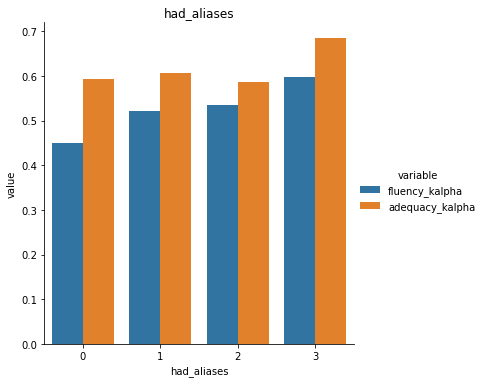

   had_aliases         variable     value
0            0   fluency_kalpha  0.449126
1            1   fluency_kalpha  0.522063
2            2   fluency_kalpha  0.535359
3            3   fluency_kalpha  0.596716
4            0  adequacy_kalpha  0.593910
5            1  adequacy_kalpha  0.606055
6            2  adequacy_kalpha  0.586455
7            3  adequacy_kalpha  0.685321
             had_aliases     value
had_aliases     1.000000  0.971749
value           0.971749  1.000000
             had_aliases     value
had_aliases     1.000000  0.720199
value           0.720199  1.000000


In [68]:
# I AM REPEATING THE CODE STRUCTURE AND JUST CHANGING THE NAME OF THE COLUMN, DONT JUDGE ME
theme_entity_label_claim_lookup = claims_crowd_df.reset_index()[['claim_id','had_aliases']].groupby('had_aliases').agg(list)
#theme_entity_label_claim_lookup = claims_crowd_df[claims_crowd_df['datatype'] == 'wikibase-item'].reset_index()[['claim_id','had_aliases']].groupby('had_aliases').agg(list)


aggreement_per_theme = []

for theme in theme_entity_label_claim_lookup.index.tolist():
    claims = theme_entity_label_claim_lookup.loc[theme,'claim_id']
    claims += claims_art
       
    data_flu_df_theme = data_flu_df[data_flu_df['claim_id'].apply(lambda x : x in claims)]
    data_ade_df_theme = data_ade_df[data_ade_df['claim_id'].apply(lambda x : x in claims)]
    agg_dict = calculate_aggreement(data_flu_df_theme, data_ade_df_theme)
    aggreement_per_theme.append({
        'had_aliases':theme,
        'fluency_kalpha':agg_dict['fluency']['kalpha'],
        'fluency_fkappa':agg_dict['fluency']['fkappa'],
        'fluency_rkappa':agg_dict['fluency']['rkappa'],
        'adequacy_kalpha':agg_dict['adequacy']['kalpha'],
        'adequacy_fkappa':agg_dict['adequacy']['fkappa'],
        'adequacy_rkappa':agg_dict['adequacy']['rkappa'],
    })
    
aggreement_per_theme = pd.DataFrame(aggreement_per_theme)

aggreement_per_theme_kalpha = aggreement_per_theme[['had_aliases','fluency_kalpha','adequacy_kalpha']]
aggreement_per_theme_melt = aggreement_per_theme_kalpha.melt(id_vars='had_aliases')

sns.catplot(y='value', x='had_aliases', data=aggreement_per_theme_melt, hue='variable', kind='bar')
plt.title('had_aliases')
plt.show()

print(aggreement_per_theme_melt)

for col in ['fluency_kalpha', 'adequacy_kalpha']:
    print(aggreement_per_theme_melt[aggreement_per_theme_melt.variable==col].corr())

# There is a clear rising trend in kalpha as more aliases are available

## Varying aggregated results

In [71]:
columns_to_keep_for_result_analysis = [
    'sampling_weight','property_label', 'theme_entity_label', 'fluency_mean', 'fluency_median', 'adequacy_maj',
    'adequacy_perc', 'had_descriptions', 'had_aliases', 'processed_verbalisation', 'datatype', 'entity_label',
    'object_label'
]
claims_crowd_df_results = claims_crowd_df[columns_to_keep_for_result_analysis]
claims_crowd_df_results['theme_group'] = claims_crowd_df_results['theme_entity_label'].apply(get_theme_group)
claims_crowd_df_results

<ipython-input-71-6f0638688e11>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claims_crowd_df_results['theme_group'] = claims_crowd_df_results['theme_entity_label'].apply(get_theme_group)


,sampling_weight,property_label,theme_entity_label,fluency_mean,fluency_median,adequacy_maj,adequacy_perc,had_descriptions,had_aliases,processed_verbalisation,datatype,entity_label,object_label,theme_group
claim_id,,,,,,,,,,,,,,
Q20451714$49CB1F7A-FC51-41CF-81EA-3EC1EC81AB5D,2.642857,use,Airport,3.8,4.0,0,0.8,3,3,Livramento Do Brumado Airport is used by gener...,wikibase-item,Livramento Do Brumado Airport,general aviation,WEBNLG_SEEN
Q1655953$CAAADB1F-5DCA-4492-8707-EEAAAE8C7035,2.642857,use,Airport,2.6,3.0,0,0.6,3,3,Confresa Airport is used by general aviation.,wikibase-item,Confresa Airport,general aviation,WEBNLG_SEEN
Q12692647$4C0066D0-8B10-433F-88F1-6AA6B01EE058,2.642857,use,Airport,4.0,4.0,0,0.8,3,3,Fazenda Bananeira Airport is used by general a...,wikibase-item,Fazenda Bananeira Airport,general aviation,WEBNLG_SEEN
Q7589682$2dd0b4b8-4b51-8876-1a25-4adf01ccfbf4,2.642857,use,Airport,4.6,5.0,0,0.8,3,2,St. Louis Regional Airport uses an air taxi.,wikibase-item,St. Louis Regional Airport,air taxi,WEBNLG_SEEN
Q9586474$814EF1BE-6ACE-4627-9EF1-D0C4A24DFE3F,2.642857,use,Airport,3.6,3.0,0,1.0,3,3,Santa Rosa do Purus Airport is used by general...,wikibase-item,Santa Rosa do Purus Airport,general aviation,WEBNLG_SEEN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q22701502$67B68648-4718-4688-9FA8-B25B76F9E708,433.187500,mountain range,Mountain,3.8,3.0,1,0.4,3,1,The Monarch is located in the Ball Range.,wikibase-item,The Monarch,Ball Range,WIKIDATA_UNSEEN
Q7424234$C84E70B9-0300-4DA6-A025-27BF4ACFEF84,433.187500,mountain range,Mountain,4.6,5.0,0,1.0,2,3,Sarkofagen Mountain is part of the Russkiye Mo...,wikibase-item,Sarkofagen Mountain,Russkiye Mountains,WIKIDATA_UNSEEN
Q21878963$35250a4e-45bb-33f8-af89-f1969bae5b87,433.187500,mountain range,Mountain,4.0,4.0,0,0.8,3,2,Kleines Schöberl is part of the Schober group.,wikibase-item,Kleines Schöberl,Schober group,WIKIDATA_UNSEEN


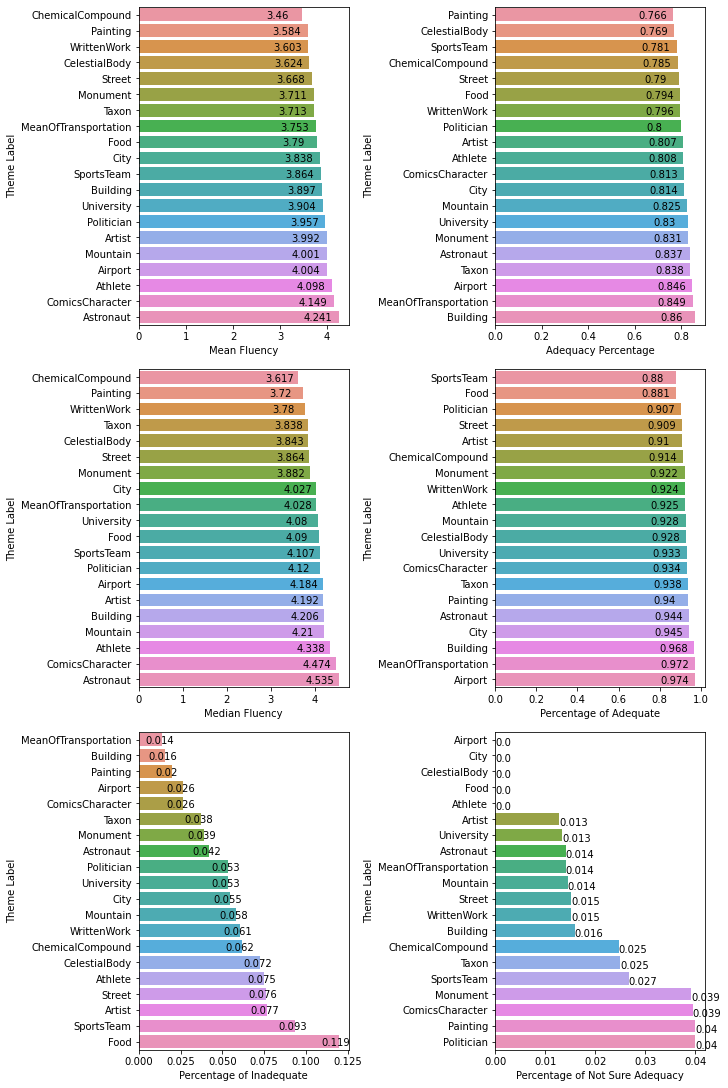

In [139]:
def generate_results_report_mediated_by(mediator, figsize_x, figsize_y, mediator_label, pads=None):
    
    if pads is None:
        pads = [0]*12
    elif len(pads) < 12:
        pads = pads + [0]*(12-len(pads))

    claims_crowd_df_results_theme_fluency = claims_crowd_df_results[[mediator,'fluency_mean','fluency_median']]#\

    fig, ax = plt.subplots(3,2,figsize=(figsize_x,figsize_y),constrained_layout=True)

    sns.barplot(
        data=claims_crowd_df_results_theme_fluency, y=mediator, x='fluency_mean', ax=ax[0][0], ci=None,
        order = claims_crowd_df_results_theme_fluency.groupby(mediator).agg('mean').sort_values('fluency_mean').index.tolist()
    )
    ax[0][0].set_xlabel('Mean Fluency')
    ax[0][0].set_ylabel(mediator_label)
    show_values_on_bars(ax[0][0], 'h', pads[0], pads[1])

    sns.barplot(
        data=claims_crowd_df_results_theme_fluency, y=mediator, x='fluency_median', ax=ax[1][0], ci=None,
        order = claims_crowd_df_results_theme_fluency.groupby(mediator).agg('mean').sort_values('fluency_median').index.tolist()
    )
    ax[1][0].set_xlabel('Median Fluency')
    ax[1][0].set_ylabel(mediator_label)
    show_values_on_bars(ax[1][0], 'h', pads[2], pads[3])

    claims_crowd_df_results_theme_adequacy_perc = claims_crowd_df_results[[mediator,'adequacy_perc']]#\

    sns.barplot(
        data=claims_crowd_df_results_theme_adequacy_perc, y=mediator, x='adequacy_perc', ax=ax[0][1], ci=None,
        order = claims_crowd_df_results_theme_adequacy_perc.groupby(mediator).agg('mean').sort_values('adequacy_perc').index.tolist()
    )
    ax[0][1].set_xlabel('Adequacy Percentage')
    ax[0][1].set_ylabel(mediator_label)
    show_values_on_bars(ax[0][1], 'h', pads[4], pads[5])

    claims_crowd_df_results_theme_adequacy_maj = claims_crowd_df_results[[mediator,'adequacy_maj']].groupby(mediator).agg(list)

    def get_proportion_elements(target, array):
        c = 0
        for element in array:
            if element == target:
                c+=1
        return c/len(array)

    claims_crowd_df_results_theme_adequacy_maj['p_0'] =\
        claims_crowd_df_results_theme_adequacy_maj.adequacy_maj.apply(lambda x : get_proportion_elements(0,x))
    claims_crowd_df_results_theme_adequacy_maj['p_1'] =\
        claims_crowd_df_results_theme_adequacy_maj.adequacy_maj.apply(lambda x : get_proportion_elements(1,x))
    claims_crowd_df_results_theme_adequacy_maj['p_2'] =\
        claims_crowd_df_results_theme_adequacy_maj.adequacy_maj.apply(lambda x : get_proportion_elements(2,x))

    claims_crowd_df_results_theme_adequacy_maj = claims_crowd_df_results_theme_adequacy_maj.drop('adequacy_maj', axis=1).reset_index()

    sns.barplot(
        data=claims_crowd_df_results_theme_adequacy_maj, y=mediator, x='p_0', ax=ax[1][1], ci=None,
        order = claims_crowd_df_results_theme_adequacy_maj.groupby(mediator).agg('mean').sort_values('p_0').index.tolist()
    )
    ax[1][1].set_xlabel('Percentage of Adequate')
    ax[1][1].set_ylabel(mediator_label)
    show_values_on_bars(ax[1][1], 'h', pads[6], pads[7])

    sns.barplot(
        data=claims_crowd_df_results_theme_adequacy_maj, y=mediator, x='p_1', ax=ax[2][0], ci=None,
        order = claims_crowd_df_results_theme_adequacy_maj.groupby(mediator).agg('mean').sort_values('p_1').index.tolist()
    )
    ax[2][0].set_xlabel('Percentage of Inadequate')
    ax[2][0].set_ylabel(mediator_label)
    show_values_on_bars(ax[2][0], 'h', pads[8], pads[9])

    sns.barplot(
        data=claims_crowd_df_results_theme_adequacy_maj, y=mediator, x='p_2', ax=ax[2][1], ci=None,
        order = claims_crowd_df_results_theme_adequacy_maj.groupby(mediator).agg('mean').sort_values('p_2').index.tolist()
    )
    ax[2][1].set_xlabel('Percentage of Not Sure Adequacy')
    ax[2][1].set_ylabel(mediator_label)
    show_values_on_bars(ax[2][1], 'h', pads[10], pads[11])

    plt.show()

    
generate_results_report_mediated_by(
    'theme_entity_label', 10, 15, 'Theme Label',
    pads=[-0.75, -0.15, -0.75, -0.15, -0.15, -0.15, -0.17, -0.15, -0.01, -0.15, 0, 0]
)
# FLUENCY MEAN AND MEDIAN ARE SELF EXPLANATORY: FOR EACH CLAIM_ID, THERE IS A FLUENCY MEAN SCORE AND A FLUENCY MEDIAN SCORE
# ADEQUACY PERC IS: FOR EACH CLAIM_ID, THE PERCENTAGE OF VOTES THAT RATED IT AS 0
# P_0 IS LESS OBVIOUS: IT IS THE PERCENTAGE OF CLAIM_IDS IN THAT THEME THAT, IN THE END, WERE MAJORITY VOTED AS 0
# P_1 AND P_2 ARE THE SAME IDEA

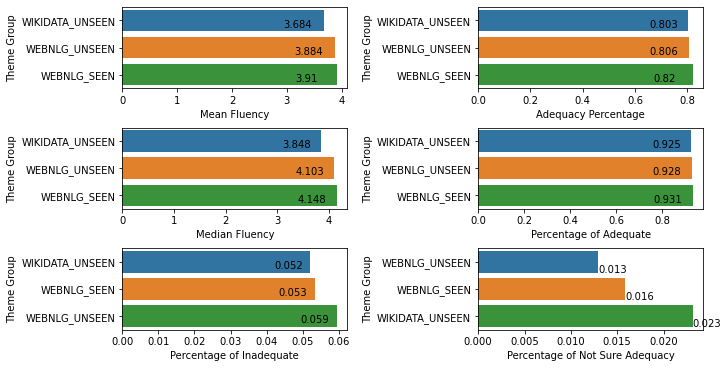

In [140]:
generate_results_report_mediated_by(
    'theme_group', 10, 5, 'Theme Group',        
    pads=[-0.75, -0.15, -0.75, -0.15, -0.15, -0.15, -0.17, -0.15, -0.01, -0.15, 0, 0]
)

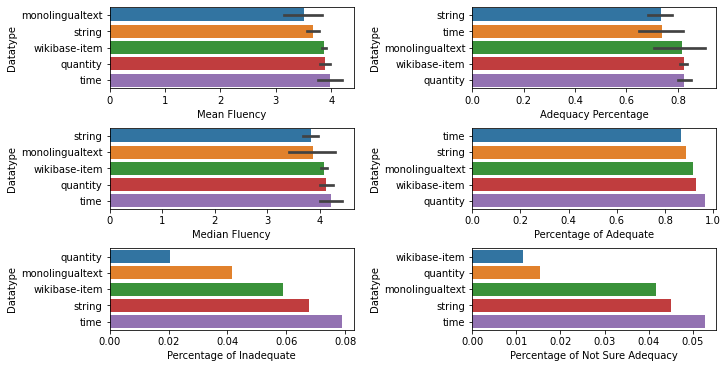

In [75]:
generate_results_report_mediated_by('datatype', 10, 5, 'Datatype')

### Weighting by sample weight

In [78]:
# FOR FINAL RESULT, WHEN REPORTING THIS ON A PAPER, TRY AVERAGING RESULTS BASED ON SAMPLE WEIGHTS, FOR OFFICIAL AND ADJUSTED
# METRICS
claims_crowd_df_results['weighted_fluency_mean'] = claims_crowd_df_results.apply(lambda x: x['fluency_mean']*x['sampling_weight'],axis=1)
claims_crowd_df_results['weighted_fluency_median'] = claims_crowd_df_results.apply(lambda x: x['fluency_median']*x['sampling_weight'],axis=1)
claims_crowd_df_results['weighted_adequacy_maj'] = claims_crowd_df_results.apply(lambda x: bool(x['adequacy_maj'])*x['sampling_weight'],axis=1)
claims_crowd_df_results['weighted_adequacy_perc'] = claims_crowd_df_results.apply(lambda x: x['adequacy_perc']*x['sampling_weight'],axis=1)

<ipython-input-78-f0ec1745a4ae>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claims_crowd_df_results['weighted_fluency_mean'] = claims_crowd_df_results.apply(lambda x: x['fluency_mean']*x['sampling_weight'],axis=1)
<ipython-input-78-f0ec1745a4ae>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claims_crowd_df_results['weighted_fluency_median'] = claims_crowd_df_results.apply(lambda x: x['fluency_median']*x['sampling_weight'],axis=1)
<ipython-input-78-f0ec1745a4ae>:5: SettingWithCopyWarning: 
A value is

In [81]:
weighted_claims_crowd_df_results_grouped_by_theme

,sampling_weight,fluency_mean,fluency_median,adequacy_maj,adequacy_perc,had_descriptions,had_aliases,weighted_fluency_mean,weighted_fluency_median,weighted_adequacy_maj,weighted_adequacy_perc
theme_entity_label,,,,,,,,,,,
Airport,4.671952e+03,304.285714,318.0,2,64.325000,209,198,4.132794,4.363767,0.912349,0.770313
Artist,1.448138e+05,311.397143,327.0,8,62.980000,208,153,4.085350,4.218591,0.989100,0.874916
Astronaut,3.690952e+02,301.114286,322.0,5,59.400000,202,165,4.389343,4.645594,0.982583,0.861024
Athlete,2.812864e+05,327.800000,347.0,6,64.625000,206,114,4.304833,4.739247,0.963334,0.899486
Building,8.197197e+04,245.485714,265.0,3,54.200000,153,99,4.004037,4.349283,0.984249,0.914583
CelestialBody,2.154410e+06,300.828571,319.0,6,63.857143,195,121,3.540216,3.887439,0.978742,0.799492
ChemicalCompound,3.664352e+04,280.271429,293.0,9,63.585714,217,138,3.177843,3.307742,0.953442,0.835634
City,7.171333e+03,280.200000,294.0,4,59.400000,200,122,4.153114,4.333327,0.995724,0.827299
ComicsCharacter,1.101050e+03,315.289286,340.0,8,61.801111,211,172,4.185324,4.403206,0.985378,0.817644


Text(0, 0.5, 'Theme')

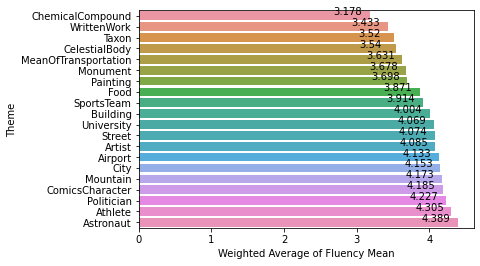

In [87]:
g = sns.barplot(
    data=weighted_claims_crowd_df_results_grouped_by_theme.reset_index(), y='theme_entity_label', x='weighted_fluency_mean',
    order = weighted_claims_crowd_df_results_grouped_by_theme.sort_values('weighted_fluency_mean').index.tolist()
)
show_values_on_bars(g, 'h', -0.5, -0.5)
g.set_xlabel('Weighted Average of Fluency Mean')
g.set_ylabel('Theme')

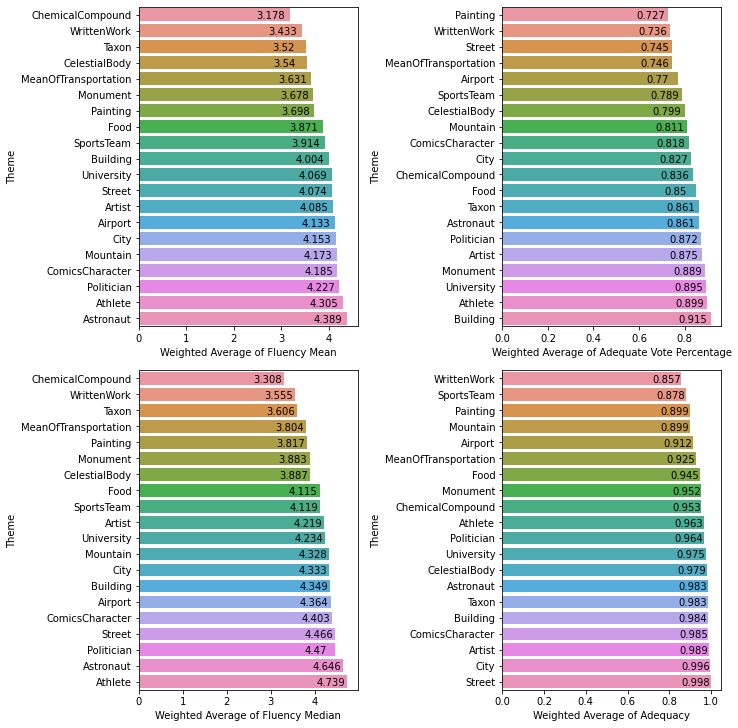

In [118]:
weighted_claims_crowd_df_results_grouped_by_theme = claims_crowd_df_results.groupby('theme_entity_label').sum()
weighted_claims_crowd_df_results_grouped_by_theme['weighted_fluency_mean'] =\
    weighted_claims_crowd_df_results_grouped_by_theme['weighted_fluency_mean']/weighted_claims_crowd_df_results_grouped_by_theme['sampling_weight']
weighted_claims_crowd_df_results_grouped_by_theme['weighted_fluency_median'] =\
    weighted_claims_crowd_df_results_grouped_by_theme['weighted_fluency_median']/weighted_claims_crowd_df_results_grouped_by_theme['sampling_weight']
weighted_claims_crowd_df_results_grouped_by_theme['weighted_adequacy_maj'] =\
    1 - (weighted_claims_crowd_df_results_grouped_by_theme['weighted_adequacy_maj']/weighted_claims_crowd_df_results_grouped_by_theme['sampling_weight'])
weighted_claims_crowd_df_results_grouped_by_theme['weighted_adequacy_perc'] =\
    weighted_claims_crowd_df_results_grouped_by_theme['weighted_adequacy_perc']/weighted_claims_crowd_df_results_grouped_by_theme['sampling_weight']

fig, ax = plt.subplots(2,2,figsize=(10,10),constrained_layout=True)

sns.barplot(
    data=weighted_claims_crowd_df_results_grouped_by_theme.reset_index(), y='theme_entity_label', x='weighted_fluency_mean', ax=ax[0][0],
    order = weighted_claims_crowd_df_results_grouped_by_theme.sort_values('weighted_fluency_mean').index.tolist()
)
show_values_on_bars(ax[0][0], 'h', -0.7, -0.15)
ax[0][0].set_xlabel('Weighted Average of Fluency Mean')
ax[0][0].set_ylabel('Theme')

sns.barplot(
    data=weighted_claims_crowd_df_results_grouped_by_theme.reset_index(), y='theme_entity_label', x='weighted_fluency_median', ax=ax[1][0],
    order = weighted_claims_crowd_df_results_grouped_by_theme.sort_values('weighted_fluency_median').index.tolist()
)
show_values_on_bars(ax[1][0], 'h', -0.7, -0.15)
ax[1][0].set_xlabel('Weighted Average of Fluency Median')
ax[1][0].set_ylabel('Theme')

sns.barplot(
    data=weighted_claims_crowd_df_results_grouped_by_theme.reset_index(), y='theme_entity_label', x='weighted_adequacy_perc', ax=ax[0][1],
    order = weighted_claims_crowd_df_results_grouped_by_theme.sort_values('weighted_adequacy_perc').index.tolist()
)
show_values_on_bars(ax[0][1], 'h', -0.14, -0.15)
ax[0][1].set_xlabel('Weighted Average of Adequate Vote Percentage')
ax[0][1].set_ylabel('Theme')

sns.barplot(
    data=weighted_claims_crowd_df_results_grouped_by_theme.reset_index(), y='theme_entity_label', x='weighted_adequacy_maj', ax=ax[1][1],
    order = weighted_claims_crowd_df_results_grouped_by_theme.sort_values('weighted_adequacy_maj').index.tolist()
)
show_values_on_bars(ax[1][1], 'h', -0.14, -0.15)
ax[1][1].set_xlabel('Weighted Average of Adequacy')
ax[1][1].set_ylabel('Theme')

#plt.tight_layout()
plt.savefig('imgs/weighted_scores.png')
plt.show()

<ipython-input-82-730e94f9c9f6>:37: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


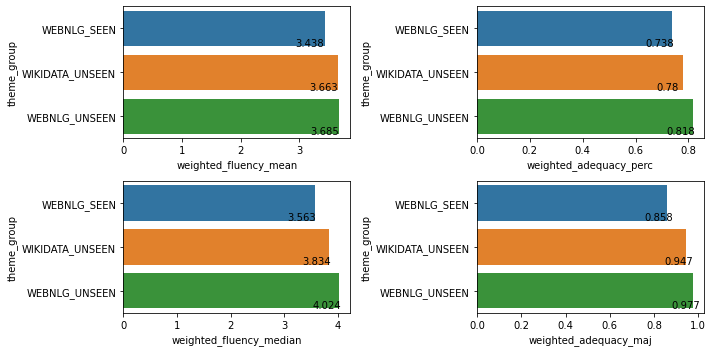

In [82]:
weighted_claims_crowd_df_results_grouped_by_theme = claims_crowd_df_results.groupby('theme_group').sum()
weighted_claims_crowd_df_results_grouped_by_theme['weighted_fluency_mean'] =\
    weighted_claims_crowd_df_results_grouped_by_theme['weighted_fluency_mean']/weighted_claims_crowd_df_results_grouped_by_theme['sampling_weight']
weighted_claims_crowd_df_results_grouped_by_theme['weighted_fluency_median'] =\
    weighted_claims_crowd_df_results_grouped_by_theme['weighted_fluency_median']/weighted_claims_crowd_df_results_grouped_by_theme['sampling_weight']
weighted_claims_crowd_df_results_grouped_by_theme['weighted_adequacy_maj'] =\
    1 - (weighted_claims_crowd_df_results_grouped_by_theme['weighted_adequacy_maj']/weighted_claims_crowd_df_results_grouped_by_theme['sampling_weight'])
weighted_claims_crowd_df_results_grouped_by_theme['weighted_adequacy_perc'] =\
    weighted_claims_crowd_df_results_grouped_by_theme['weighted_adequacy_perc']/weighted_claims_crowd_df_results_grouped_by_theme['sampling_weight']

fig, ax = plt.subplots(2,2,figsize=(10,5),constrained_layout=True)

sns.barplot(
    data=weighted_claims_crowd_df_results_grouped_by_theme.reset_index(), y='theme_group', x='weighted_fluency_mean', ax=ax[0][0],
    order = weighted_claims_crowd_df_results_grouped_by_theme.sort_values('weighted_fluency_mean').index.tolist()
)
show_values_on_bars(ax[0][0], 'h', -0.5)

sns.barplot(
    data=weighted_claims_crowd_df_results_grouped_by_theme.reset_index(), y='theme_group', x='weighted_fluency_median', ax=ax[1][0],
    order = weighted_claims_crowd_df_results_grouped_by_theme.sort_values('weighted_fluency_median').index.tolist()
)
show_values_on_bars(ax[1][0], 'h', -0.5)

sns.barplot(
    data=weighted_claims_crowd_df_results_grouped_by_theme.reset_index(), y='theme_group', x='weighted_adequacy_perc', ax=ax[0][1],
    order = weighted_claims_crowd_df_results_grouped_by_theme.sort_values('weighted_adequacy_perc').index.tolist()
)
show_values_on_bars(ax[0][1], 'h', -0.1)

sns.barplot(
    data=weighted_claims_crowd_df_results_grouped_by_theme.reset_index(), y='theme_group', x='weighted_adequacy_maj', ax=ax[1][1],
    order = weighted_claims_crowd_df_results_grouped_by_theme.sort_values('weighted_adequacy_maj').index.tolist()
)
show_values_on_bars(ax[1][1], 'h', -0.1)

plt.tight_layout()

plt.show()

## Looking at specific examples

### Non-fluent totals

In [141]:
claims_crowd_df_results_not_fluent = claims_crowd_df_results[claims_crowd_df_results['fluency_median'] < 3]

In [144]:
claims_crowd_df_results_not_fluent.shape[0]

55

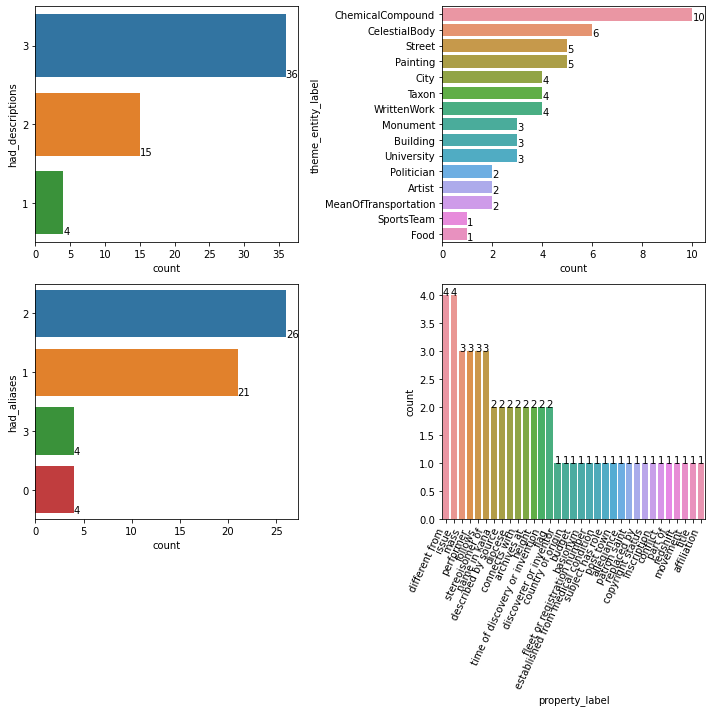

In [151]:
fig, ax = plt.subplots(2,2,figsize=(10,10))

g = sns.countplot(
    data=claims_crowd_df_results_not_fluent, y='had_descriptions', orient='v',
    order=claims_crowd_df_results_not_fluent.had_descriptions.value_counts().keys(), ax=ax[0][0]
)
show_values_on_bars(g,'h')

g = sns.countplot(
    data=claims_crowd_df_results_not_fluent, y='had_aliases', orient='v',
    order=claims_crowd_df_results_not_fluent.had_aliases.value_counts().keys(), ax=ax[1][0]
)
show_values_on_bars(g,'h')

g= sns.countplot(
    data=claims_crowd_df_results_not_fluent, y='theme_entity_label', orient='v',
    order=claims_crowd_df_results_not_fluent.theme_entity_label.value_counts().keys(), ax=ax[0][1]
)
show_values_on_bars(g,'h')

g = sns.countplot(
    data=claims_crowd_df_results_not_fluent, x='property_label', orient='v',
    order=claims_crowd_df_results_not_fluent.property_label.value_counts().keys(), ax=ax[1][1]
)
show_values_on_bars(g,'v')
g.set_xticklabels(g.get_xticklabels(), rotation=65,ha='right')

plt.tight_layout()
plt.show()

### Non-fluent percentage

In [191]:
claims_crowd_df_results['not_fluent'] = claims_crowd_df_results['fluency_median'].apply(lambda x : (1 if (x <3) else 0))

<ipython-input-191-bf5c0c4974f1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claims_crowd_df_results['not_fluent'] = claims_crowd_df_results['fluency_median'].apply(lambda x : (1 if (x <3) else 0))


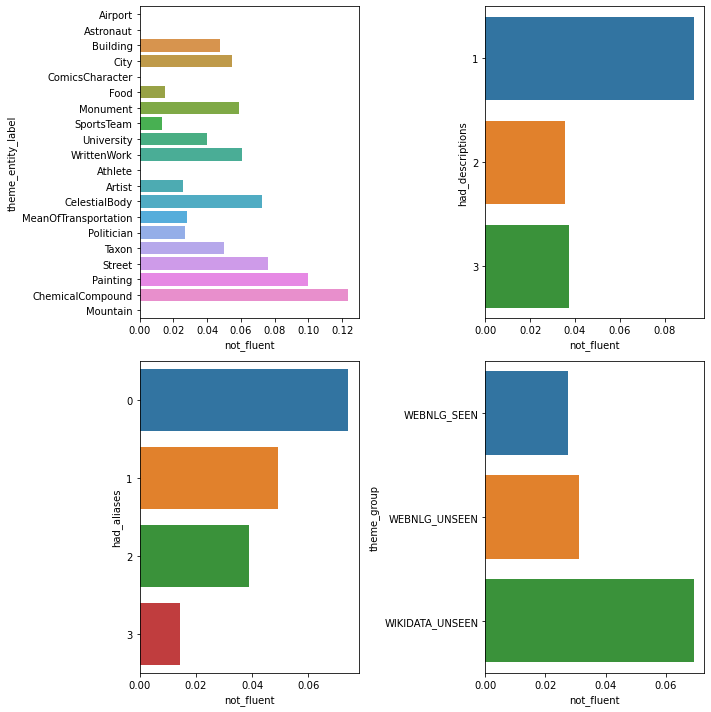

In [192]:
fig, ax = plt.subplots(2,2,figsize=(10,10))

sns.barplot(data = claims_crowd_df_results, y='theme_entity_label', x='not_fluent', ax=ax[0][0], ci=None, orient='h')

sns.barplot(data = claims_crowd_df_results, y='had_descriptions', x='not_fluent', ax=ax[0][1], ci=None, orient='h')

sns.barplot(data = claims_crowd_df_results, y='had_aliases', x='not_fluent', ax=ax[1][0], ci=None, orient='h')

sns.barplot(data = claims_crowd_df_results, y='theme_group', x='not_fluent', ax=ax[1][1], ci=None, orient='h')

plt.tight_layout()
plt.show()

### Non-fluent examples

In [153]:
claims_crowd_df_results_not_fluent.to_csv('claims_crowd_df_results_not_fluent.csv', index=None)

In [177]:
for i, row in claims_crowd_df_results_not_fluent.sort_values('fluency_mean').iterrows():
    print(
        row['theme_entity_label'], row['entity_label'], row['property_label'],
        row['object_label'], row['fluency_median'], sep=' | '
    )
    print(row['processed_verbalisation'], end='\n\n')

ChemicalCompound | 1-[(3S,9S,10S)-12-[(2R)-1-hydroxypropan-2-yl]-3,10-dimethyl-9-[[methyl(pyridin-4-ylmethyl)amino]methyl]-13-oxo-2,8-dioxa-12-azabicyclo[12.4.0]octadeca-1(14),15,17-trien-16-yl]-3-propan-2-ylurea | stereoisomer of | 1-[(3R,9R,10S)-12-[(2R)-1-hydroxypropan-2-yl]-3,10-dimethyl-9-[[methyl(pyridin-4-ylmethyl)amino]methyl]-13-oxo-2,8-dioxa-12-azabicyclo[12.4.0]octadeca-1(14),15,17-trien-16-yl]-3-propan-2-ylurea | 0.0
1-[(3R,9R,10S)-12-[(2R)-1-hydroxypropan-2-yl]-3,10-dimethyl-9-[[methyl(pyridin-4-ylmethyl)amino]methyl]-13-oxo-2,8-dioxa-12-azabicyclo[12.4.0]octadeca-1(14),15,17-trien-16-yl]-3-propan-2-ylurea is

City | Bydgoszcz | flag | flag of Bydgoszcz | 0.0
The flag of Bydgoszcz is the flag of Bydgoszcz.

CelestialBody | (15976) 1998 FY119 | time of discovery or invention | 20/03/1998 | 2.0
15976) 1998 FY119 was invented on 20/03/1998.

Taxon | Michelia subg. Anisochlamys | basionym | Michelia sect. Anisochlamys | 1.0
Michelia subg. Anisochlamys is basionym for Michelia 

### Non-adequate total

In [158]:
claims_crowd_df_results_not_adequate = claims_crowd_df_results[claims_crowd_df_results['adequacy_maj'] == 1]

In [159]:
claims_crowd_df_results_not_adequate.shape

(78, 18)

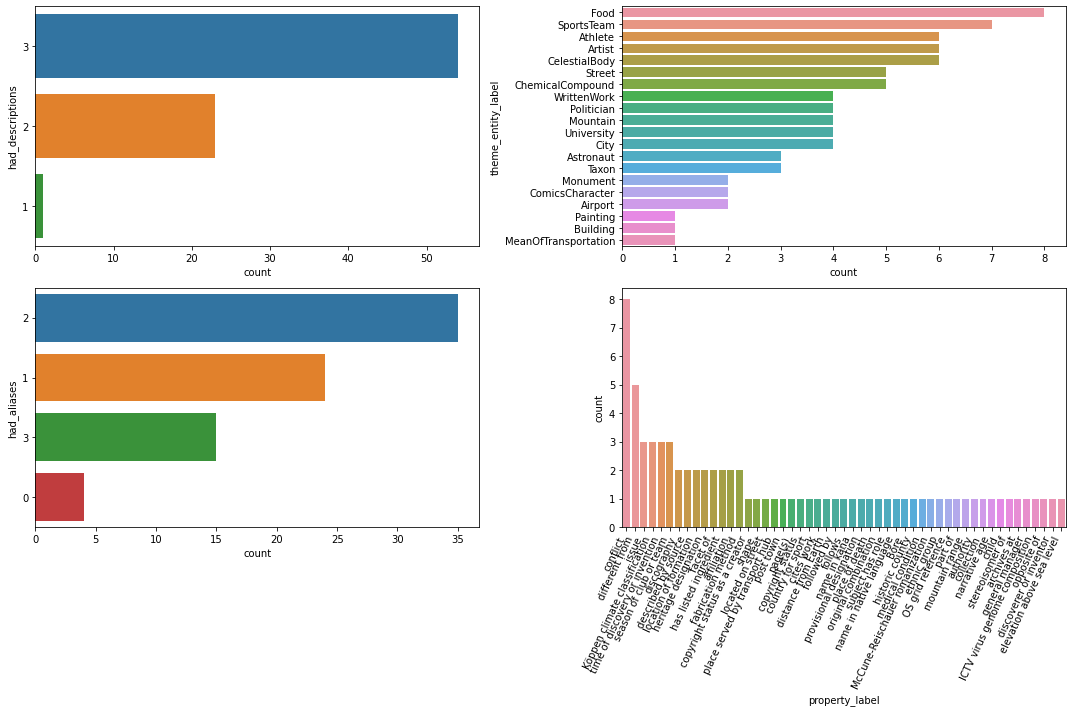

In [247]:
fig, ax = plt.subplots(2,2,figsize=(15,10))

sns.countplot(
    data=claims_crowd_df_results_not_adequate, y='had_descriptions', orient='v',
    order=claims_crowd_df_results_not_adequate.had_descriptions.value_counts().keys(), ax=ax[0][0]
)

sns.countplot(
    data=claims_crowd_df_results_not_adequate, y='had_aliases', orient='v',
    order=claims_crowd_df_results_not_adequate.had_aliases.value_counts().keys(), ax=ax[1][0]
)

sns.countplot(
    data=claims_crowd_df_results_not_adequate, y='theme_entity_label', orient='v',
    order=claims_crowd_df_results_not_adequate.theme_entity_label.value_counts().keys(), ax=ax[0][1]
)

g = sns.countplot(
    data=claims_crowd_df_results_not_adequate, x='property_label', orient='v',
    order=claims_crowd_df_results_not_adequate.property_label.value_counts().keys(), ax=ax[1][1]
)
g.set_xticklabels(g.get_xticklabels(), rotation=65,ha='right')

plt.tight_layout()
plt.show()

### Not adequate percentage

In [161]:
claims_crowd_df_results_without_not_sure = claims_crowd_df_results[claims_crowd_df_results['adequacy_maj'] != 2]

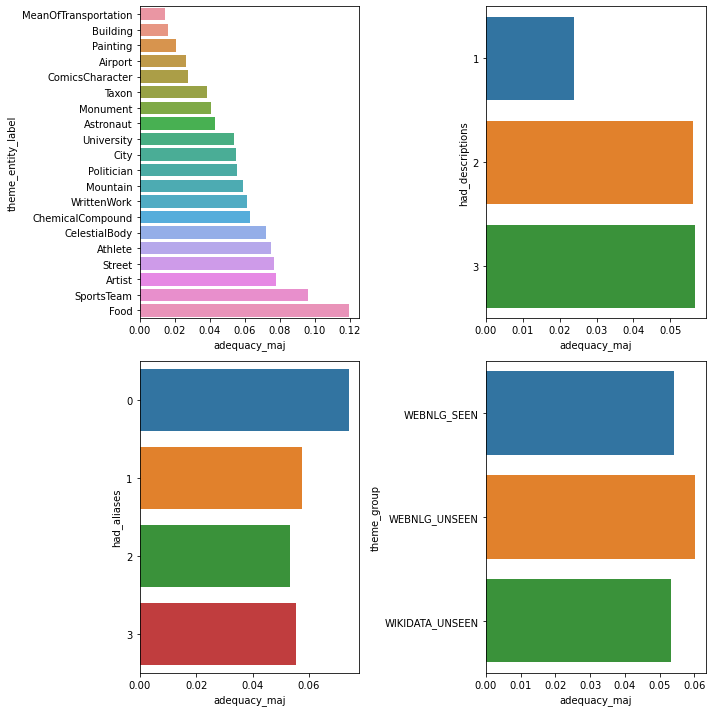

In [174]:
fig, ax = plt.subplots(2,2,figsize=(10,10))

sns.barplot(data = claims_crowd_df_results_without_not_sure, y='theme_entity_label', x='adequacy_maj', ax=ax[0][0], ci=None, orient='h',
           order = claims_crowd_df_results_without_not_sure.groupby('theme_entity_label').mean()['adequacy_maj'].sort_values().index)

sns.barplot(data = claims_crowd_df_results_without_not_sure, y='had_descriptions', x='adequacy_maj', ax=ax[0][1], ci=None, orient='h')

sns.barplot(data = claims_crowd_df_results_without_not_sure, y='had_aliases', x='adequacy_maj', ax=ax[1][0], ci=None, orient='h')

sns.barplot(data = claims_crowd_df_results_without_not_sure, y='theme_group', x='adequacy_maj', ax=ax[1][1], ci=None, orient='h')

plt.tight_layout()
plt.show()

In [175]:
claims_crowd_df_results_not_adequate.to_csv('claims_crowd_df_results_not_adequate.csv', index=None)

In [192]:
claims_crowd_df_results_not_adequate.shape

(78, 18)

In [355]:
for i, row in claims_crowd_df_results_not_adequate.sort_values('adequacy_perc').iterrows():
    print(
        row['theme_entity_label'], row['entity_label'], row['property_label'],
        row['object_label'], row['adequacy_maj'], row['adequacy_perc'], sep=' | '
    )
    print(row['processed_verbalisation'], end='\n\n')

Artist | Gru | discography | Gru discography | 1 | 0.0
The discography of Gru is extensive.

CelestialBody | (182176) 2000 SM250 | time of discovery or invention | 24/09/2000 | 1 | 0.0
The invention of the SM250 was made on 24/09/2000 and was discovered on 182176.

CelestialBody | (198156) 2004 TB66 | discoverer or inventor | Lowell Observatory Near-Earth-Object Search | 1 | 0.0
Lowell Observatory Near-Earth-Object Search was the inventor of (198156) 2004 TB66.

University | University of Tsukuba | name in kana | つくばだいがく | 1 | 0.0
The name of the University of Tsukuba is kana.

Building | Rikalantie 10 | post town | Helsinki | 1 | 0.0
Rikalantie 10 is a post town in Helsinki.

Artist | Georgiy Pavlovitsj Pavlov | conflict | Eastern Front | 1 | 0.19999999999999996
Georgiy Pavlovitsj Pavlov is in the Eastern Front.

SportsTeam | 2019 Delko-Marseille Provence | season of club or team | Delko Marseille Provence | 1 | 0.19999999999999996
Delko-Marseille Provence is in season of club or team